In [1]:
!pip install pyldavis==3.2.2


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\ahmad\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import pyLDAvis
import pyLDAvis.sklearn

# Additional libraries for advanced analysis
from wordcloud import WordCloud
from collections import Counter
import gensim
from gensim import corpora
from gensim.models import LdaModel
from textblob import TextBlob

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load dataset
df = pd.read_csv('sampel_data_semifinal_satria_data_2024.xlsx - Sheet1.csv')

# Load stopwords
stopword = []
with open('stopwords.txt', 'r', encoding='utf-8') as file:
    for word in file:
        stopword.append(word.strip())
    
# Load slangwords
slangwords = {}
with open('slangwords.txt', 'r', encoding='utf-8') as file:
    for line in file:
        words = line.split(",")
        if len(words) >= 2:
            old = words[0].strip()
            new = words[1].strip()
            slangwords[old] = new

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Stopwords loaded: {len(stopword)} words")
print(f"Slangwords loaded: {len(slangwords)} mappings")

print("\nColumn Info:")
print(df.info())

Dataset loaded: 50000 rows, 11 columns
Stopwords loaded: 719 words
Slangwords loaded: 15947 mappings

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   created_at    49987 non-null  object 
 1   tcode         49993 non-null  object 
 2   num_retweets  49987 non-null  float64
 3   type          49990 non-null  object 
 4   frn_cnt       49987 non-null  float64
 5   flw_cnt       49987 non-null  float64
 6   sts_cnt       49987 non-null  float64
 7   loc           20867 non-null  object 
 8   lst_cnt       49979 non-null  float64
 9   content       49979 non-null  object 
 10  lang          49979 non-null  object 
dtypes: float64(5), object(6)
memory usage: 4.2+ MB
None


In [4]:
# Display dataset info
print("\nDataset Overview:")
df.head()


Dataset Overview:


,created_at,tcode,num_retweets,type,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,content,lang
0,1/4/24 16:57,rt,1248.0,twit,266.0,107.0,9687.0,NaN,0.0,RT K-Popers Berencana Kirim Food Truck untuk A...,id
1,1/4/24 16:57,rt,195.0,twit,564.0,303.0,12461.0,indonesia kaya,2.0,RT Bapak Pendeta Yusak ini Dari Magetan ke Pon...,id
2,1/4/24 16:57,rt,116.0,twit,376.0,156.0,7488.0,Indonesia,1.0,"RT Viral , Gimana Mak Mak di jakarta tidak ter...",id
3,1/4/24 16:57,rt,2264.0,twit,163.0,203.0,2065.0,NaN,0.0,"RT Mendengar Pak Anies disini, rasanya saya su...",id
4,1/4/24 16:57,rt,1157.0,twit,1.0,1.0,798.0,NaN,0.0,RT Media Asing Soroti Cara Anies Gaet Pemilih ...,id


In [5]:
def filtering(review, remove_numbers=True):
    if pd.isna(review):
        return ""
    
    review = str(review)
    
    # Remove retweet tags dalam bentuk RT
    review = re.sub(r'RT', '', review)
    # Remove reply tags dalam bentuk [RE {username}]
    review = re.sub(r'\[RE \w+\]', '', review)
    
    review = re.sub(r'@\S+', ' ', review)
    review = re.sub(r'@[\w\.]+\b', ' ', review)
    review = re.sub(r'@\w+', ' ', review)

    # Menghapus URL
    review = re.sub(r'https?://\S+', ' ', review)
    review = re.sub(r'\S*\.(com|org|co)/\w*\b', ' ', review)

    review = re.sub(r"[.,:;]", " ", review)

    # Menghapus kata setelah tanda pagar (#) hanya jika jumlah hashtag tepat 3
    hashtags = re.findall(r'#([^\s]+)', review)
    for hashtag in hashtags:
        review = re.sub(r'#' + re.escape(hashtag) + r'\b', ' ', review)
    
    review = re.sub(r"\d", " ", review) if remove_numbers else review
    review = re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\*]", " ", review)
    review = re.sub(r'[^\x00-\x7f]', r' ', review)
    review = re.sub(r'(\\u[0-9A-Fa-f]+)', r' ', review)
    review = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", review)
    review = re.sub(r'\\u\w\w\w\w', ' ', review)
    review = re.sub(r'@\w+\b', ' ', review)
    review = re.sub(r'\s+', ' ', review)

    # Remove some words
    rmv = ['a', 'href', 'quot']
    try:
        review = word_tokenize(review.lower())
        review = [str(token).strip() for token in review if token not in rmv and len(token) > 2]
        review = ' '.join(review)
    except:
        review = review.lower()

    return review.strip()

def convertToSlangword(review):
    if pd.isna(review) or review == "":
        return ""
    
    review = str(review).split()
    content = []
    for kata in review:
        if kata in slangwords:
            new_kata = slangwords[kata]
        else:
            new_kata = kata
        content.append(new_kata.lower())
    return ' '.join(content)

def remove_stopwords(text):
    if pd.isna(text) or text == "":
        return ""
    
    words = text.split()
    filtered_words = [word for word in words if word not in stopword and len(word) > 2]
    return ' '.join(filtered_words)

print("Text preprocessing functions defined successfully!")

Text preprocessing functions defined successfully!


In [6]:
# Apply preprocessing
print("Starting text preprocessing...")

# Step 1: Basic filtering
df['content_cleaned'] = df['content'].apply(lambda x: filtering(x, remove_numbers=True))
print("✓ Basic filtering completed")

# Step 2: Convert slangwords
df['content_cleaned'] = df['content_cleaned'].apply(lambda x: convertToSlangword(x))
print("✓ Slangword conversion completed")

# Step 3: Remove stopwords
df['content_cleaned'] = df['content_cleaned'].apply(lambda x: remove_stopwords(x))
print("✓ Stopword removal completed")

# Remove empty content
df = df[df['content_cleaned'].str.len() > 10].copy()
print(f"✓ Dataset after cleaning: {len(df)} documents")

# Display some examples
print("\nExample of cleaned content:")
for i in range(3):
    print(f"\nOriginal: {df.iloc[i]['content'][:100]}...")
    print(f"Cleaned:  {df.iloc[i]['content_cleaned'][:100]}...")

Starting text preprocessing...
✓ Basic filtering completed
✓ Slangword conversion completed
✓ Stopword removal completed
✓ Dataset after cleaning: 49653 documents

Example of cleaned content:

Original: RT K-Popers Berencana Kirim Food Truck untuk Anies Baswedan di Acara Desak Anies https://t.co/xp14zf...
Cleaned:  popers rencana kirim food truck anies baswedan acara desak anies...

Original: RT Bapak Pendeta Yusak ini Dari Magetan ke Ponorogo Jawa timur hadir Untuk Memberikan Dukungan ke Pa...
Cleaned:  pendeta yusak magetan ponorogo jawa timur hadir ikan dukungan anies baswedan memfitnah anies intoler...

Original: RT Viral , Gimana Mak Mak di jakarta tidak ter Anies Anies ... https://t.co/sBVNn8To6Q https://t.co/...
Cleaned:  viral mak mak jakarta tidak ter anies anies...


=== DATASET STATISTICS ===
Total documents: 49653
Average content length: 121.37 characters
Median content length: 97.00 characters
Average words per document: 16.87
Median words per document: 13.00

=== TOP 20 MOST COMMON WORDS ===
anies: 29287
ganjar: 19799
prabowo: 17231
presiden: 13596
mahfud: 11289
tidak: 11043
calon: 10864
pranowo: 9179
indonesia: 8548
gibran: 5458
program: 5205
bisa: 4789
desak: 4379
pilih: 4271
orang: 4153
rakyat: 4095
tapi: 3917
baswedan: 3908
bukan: 3759
pimpin: 3723


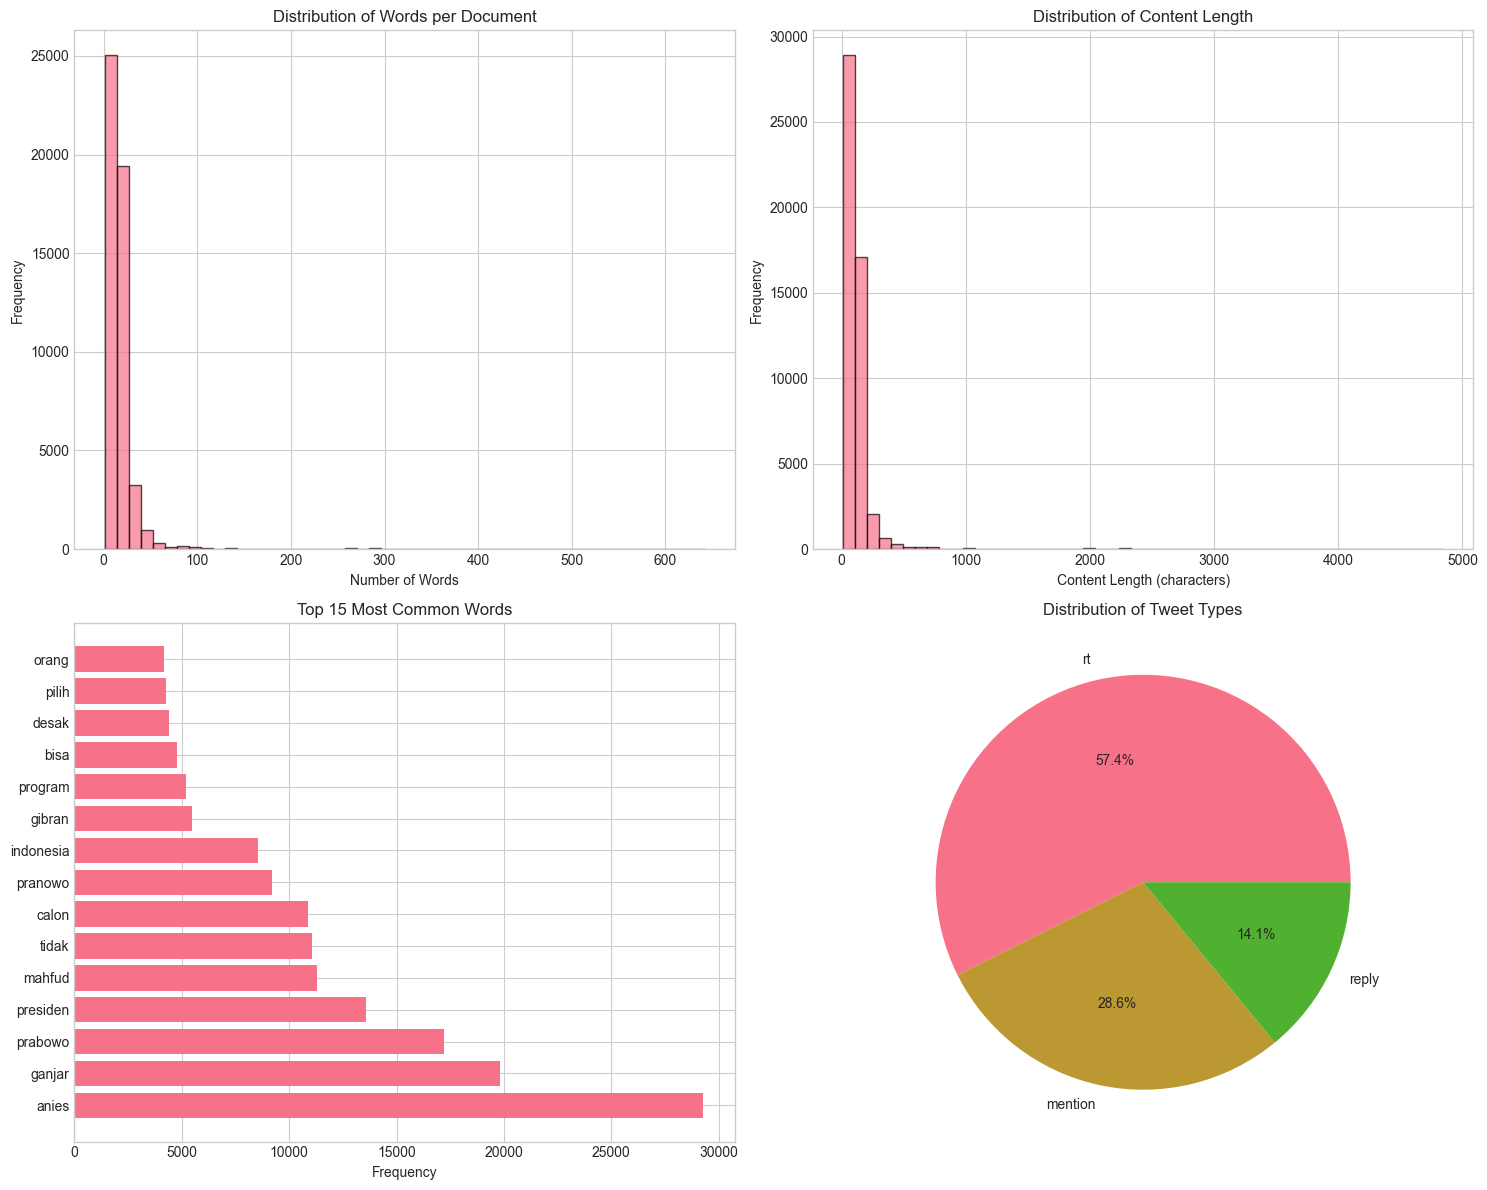

In [7]:
# Basic statistics
print("=== DATASET STATISTICS ===")
print(f"Total documents: {len(df)}")
print(f"Average content length: {df['content_cleaned'].str.len().mean():.2f} characters")
print(f"Median content length: {df['content_cleaned'].str.len().median():.2f} characters")

# Word count analysis
word_counts = df['content_cleaned'].str.split().str.len()
print(f"Average words per document: {word_counts.mean():.2f}")
print(f"Median words per document: {word_counts.median():.2f}")

# Most common words
all_words = ' '.join(df['content_cleaned']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

print("\n=== TOP 20 MOST COMMON WORDS ===")
for word, count in common_words:
    print(f"{word}: {count}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Word count distribution
axes[0,0].hist(word_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribution of Words per Document')
axes[0,0].set_xlabel('Number of Words')
axes[0,0].set_ylabel('Frequency')

# Content length distribution
axes[0,1].hist(df['content_cleaned'].str.len(), bins=50, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Distribution of Content Length')
axes[0,1].set_xlabel('Content Length (characters)')
axes[0,1].set_ylabel('Frequency')

# Top words bar chart
words, counts = zip(*common_words[:15])
axes[1,0].barh(words, counts)
axes[1,0].set_title('Top 15 Most Common Words')
axes[1,0].set_xlabel('Frequency')

# Tweet type distribution
type_counts = df['tcode'].value_counts()
axes[1,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Distribution of Tweet Types')

plt.tight_layout()
plt.show()

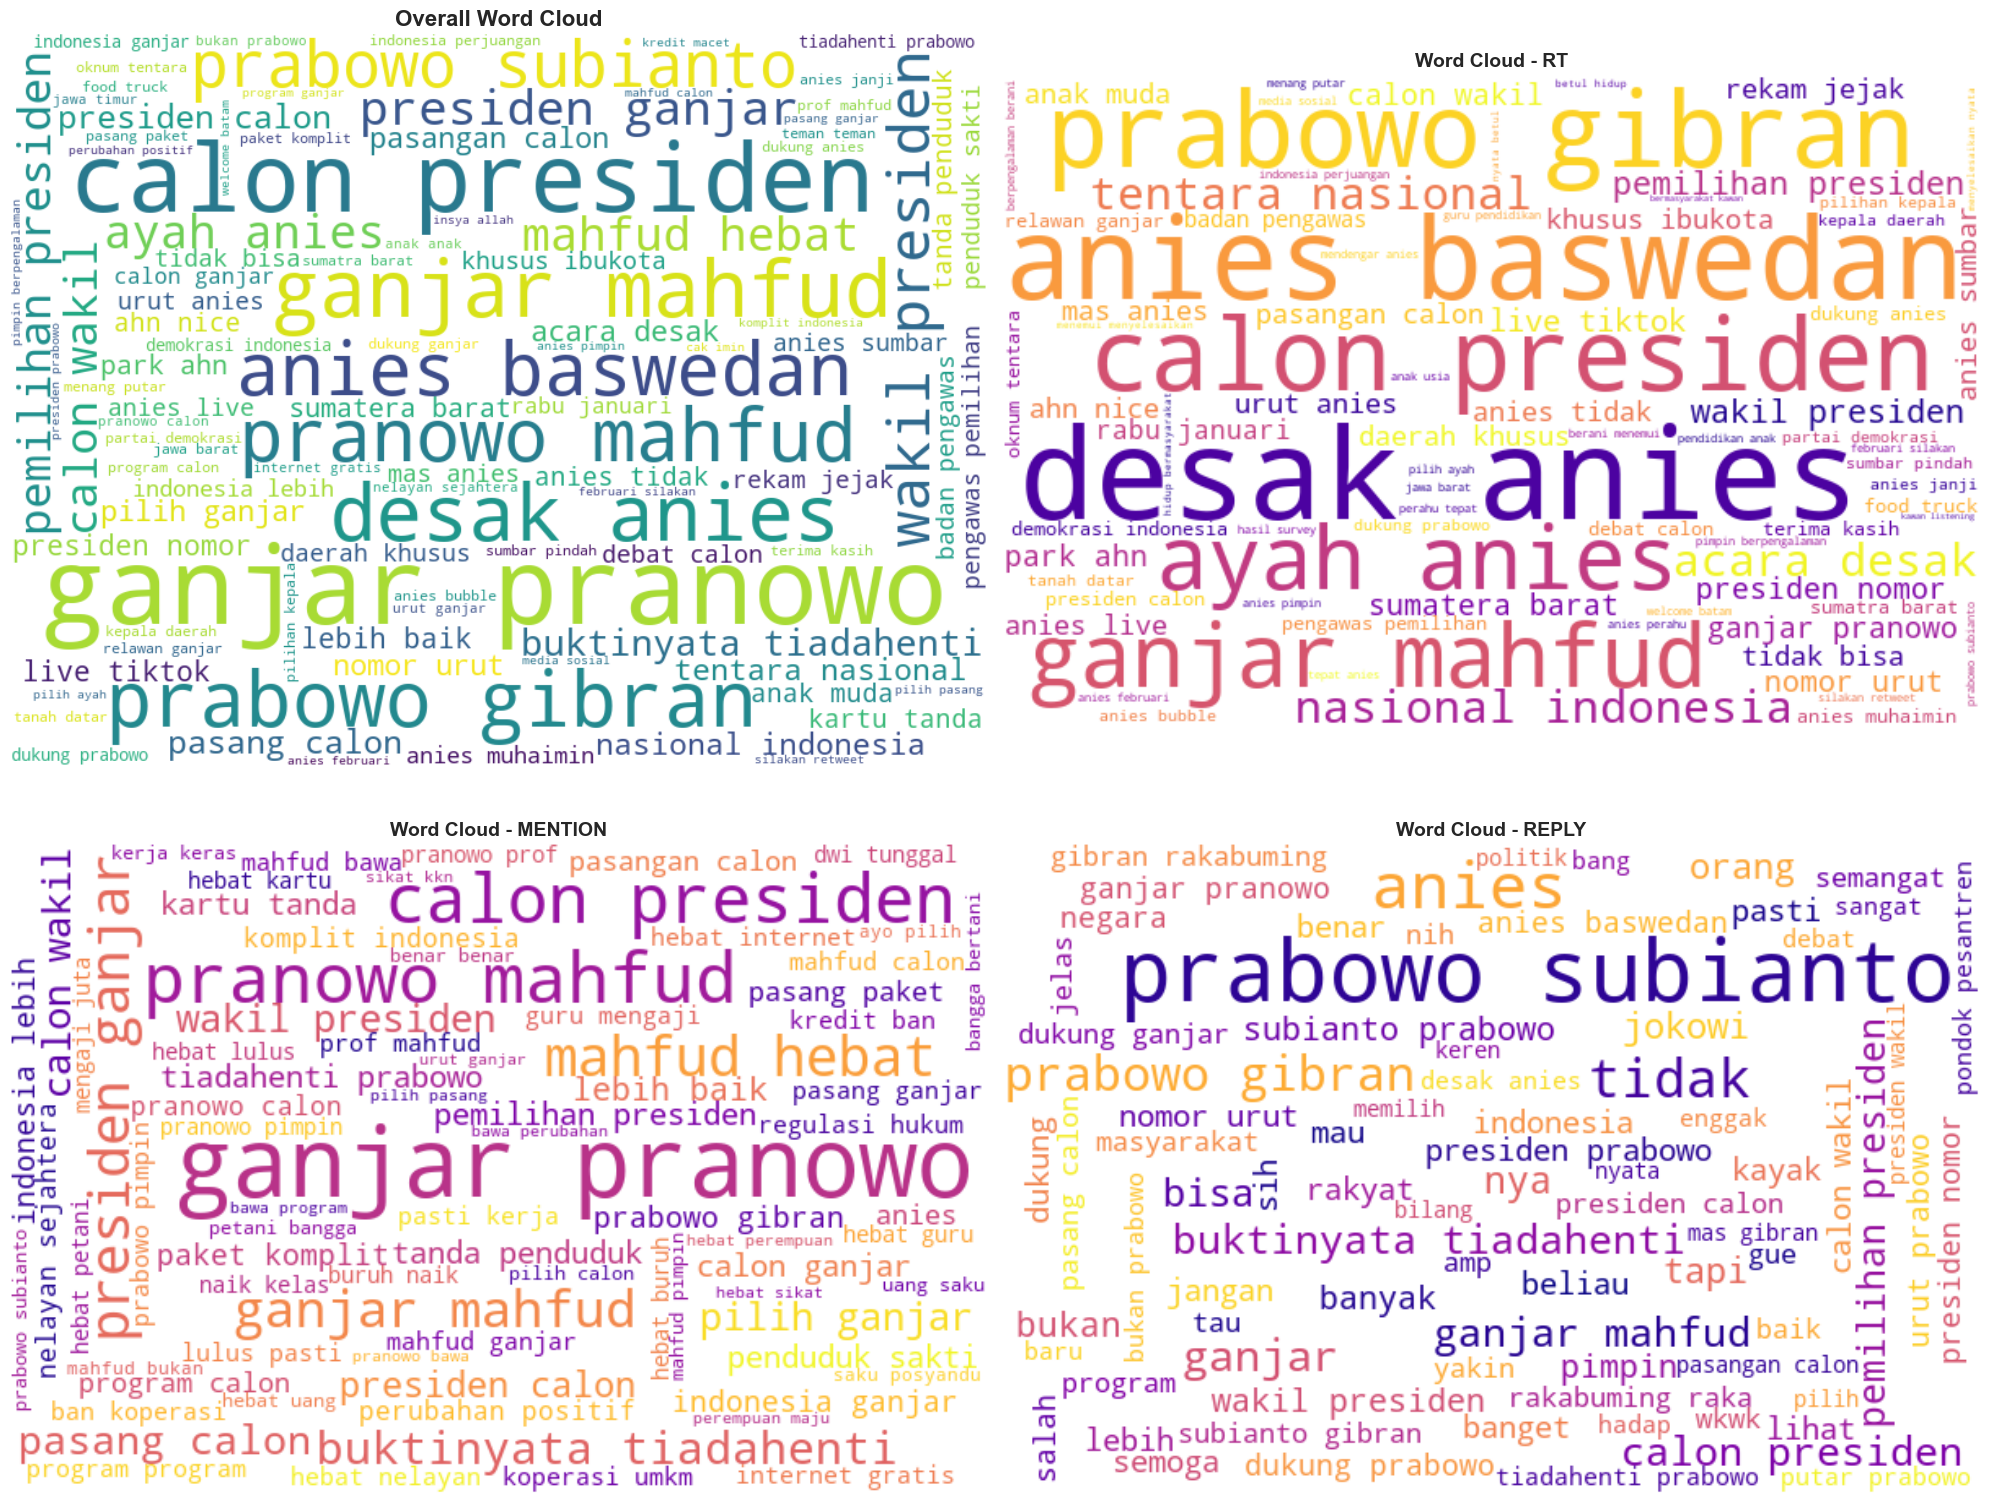

In [8]:
# Generate comprehensive word clouds
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Overall word cloud
all_text = ' '.join(df['content_cleaned'])
wordcloud_all = WordCloud(width=800, height=600, 
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(all_text)

axes[0,0].imshow(wordcloud_all, interpolation='bilinear')
axes[0,0].set_title('Overall Word Cloud', fontsize=16, fontweight='bold')
axes[0,0].axis('off')

# Word cloud by tweet type
tweet_types = ['rt', 'mention', 'reply']
for i, tweet_type in enumerate(tweet_types[:3]):
    if tweet_type in df['tcode'].values:
        type_text = ' '.join(df[df['tcode'] == tweet_type]['content_cleaned'])
        if len(type_text) > 100:
            wordcloud_type = WordCloud(width=600, height=400,
                                     background_color='white',
                                     max_words=80,
                                     colormap='plasma').generate(type_text)
            
            row = (i + 1) // 2
            col = (i + 1) % 2
            axes[row, col].imshow(wordcloud_type, interpolation='bilinear')
            axes[row, col].set_title(f'Word Cloud - {tweet_type.upper()}', fontsize=14, fontweight='bold')
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()

=== TF-IDF VECTORIZATION ===
TF-IDF Matrix Shape: (49653, 5000)
Number of features: 5000

=== TOP 30 TF-IDF FEATURES ===
anies: 2209.7067
ganjar: 1920.2628
prabowo: 1827.7688
presiden: 1295.7791
mahfud: 1291.8412
calon: 1123.3639
pranowo: 1088.5419
ganjar pranowo: 1057.8127
tidak: 1035.8297
indonesia: 929.1987
calon presiden: 784.5709
ganjar mahfud: 726.1835
desak: 713.6814
desak anies: 700.2113
gibran: 698.0067
program: 681.8345
pilih: 651.1913
subianto: 603.0009
prabowo subianto: 601.9215
prabowo gibran: 587.7860
pranowo mahfud: 576.3773
rakyat: 572.9137
bisa: 568.9094
pimpin: 552.1075
dukung: 530.4559
bukan: 528.1906
ayah: 517.1247
tapi: 509.7601
baswedan: 508.5900
orang: 491.8723


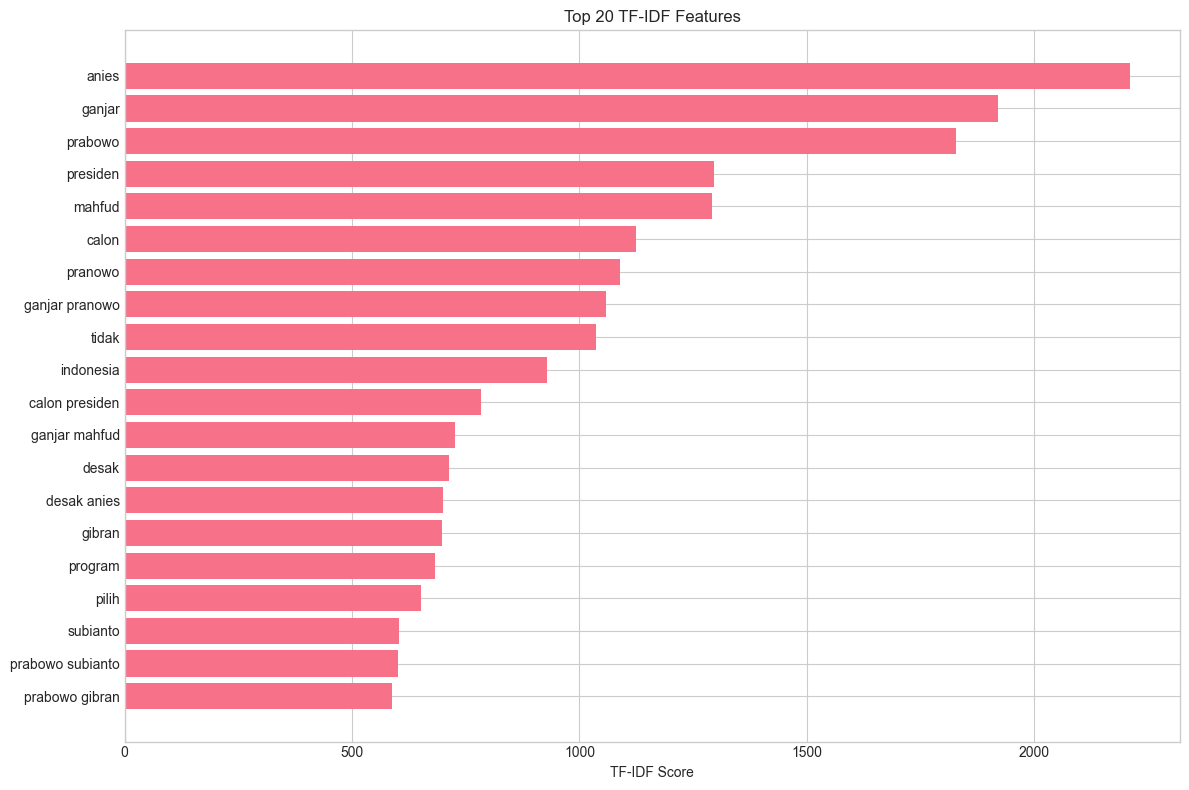

In [9]:
# TF-IDF Vectorization
print("=== TF-IDF VECTORIZATION ===")

# Create TF-IDF vectors
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words=stopword
)

tfidf_matrix = vectorizer.fit_transform(df['content_cleaned'])
feature_names = vectorizer.get_feature_names_out()

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(feature_names)}")

# Get top TF-IDF features
feature_scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_features_idx = feature_scores.argsort()[-30:][::-1]
top_features = [(feature_names[i], feature_scores[i]) for i in top_features_idx]

print("\n=== TOP 30 TF-IDF FEATURES ===")
for feature, score in top_features:
    print(f"{feature}: {score:.4f}")

# Visualize top TF-IDF features
plt.figure(figsize=(12, 8))
features, scores = zip(*top_features[:20])
plt.barh(range(len(features)), scores)
plt.yticks(range(len(features)), features)
plt.xlabel('TF-IDF Score')
plt.title('Top 20 TF-IDF Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

=== FINDING OPTIMAL NUMBER OF TOPICS ===

📊 Preparing data for analysis...


Data Preparation:   0%|          | 0/4 [00:00<?, ?step/s]

✅ Data preparation completed!
📈 Dictionary size: 7,616 unique words
📄 Corpus size: 49,653 documents
📝 Average words per document: 16.9

🎯 Starting coherence analysis...
Will train 6 LDA models (topics: [3, 5, 7, 9, 11, 13])
This may take several minutes depending on data size...


Training LDA Models:   0%|          | 0/6 [00:00<?, ?model/s]

✅ Completed training 6 models!
⏱️ Total analysis time: 6.5 minutes


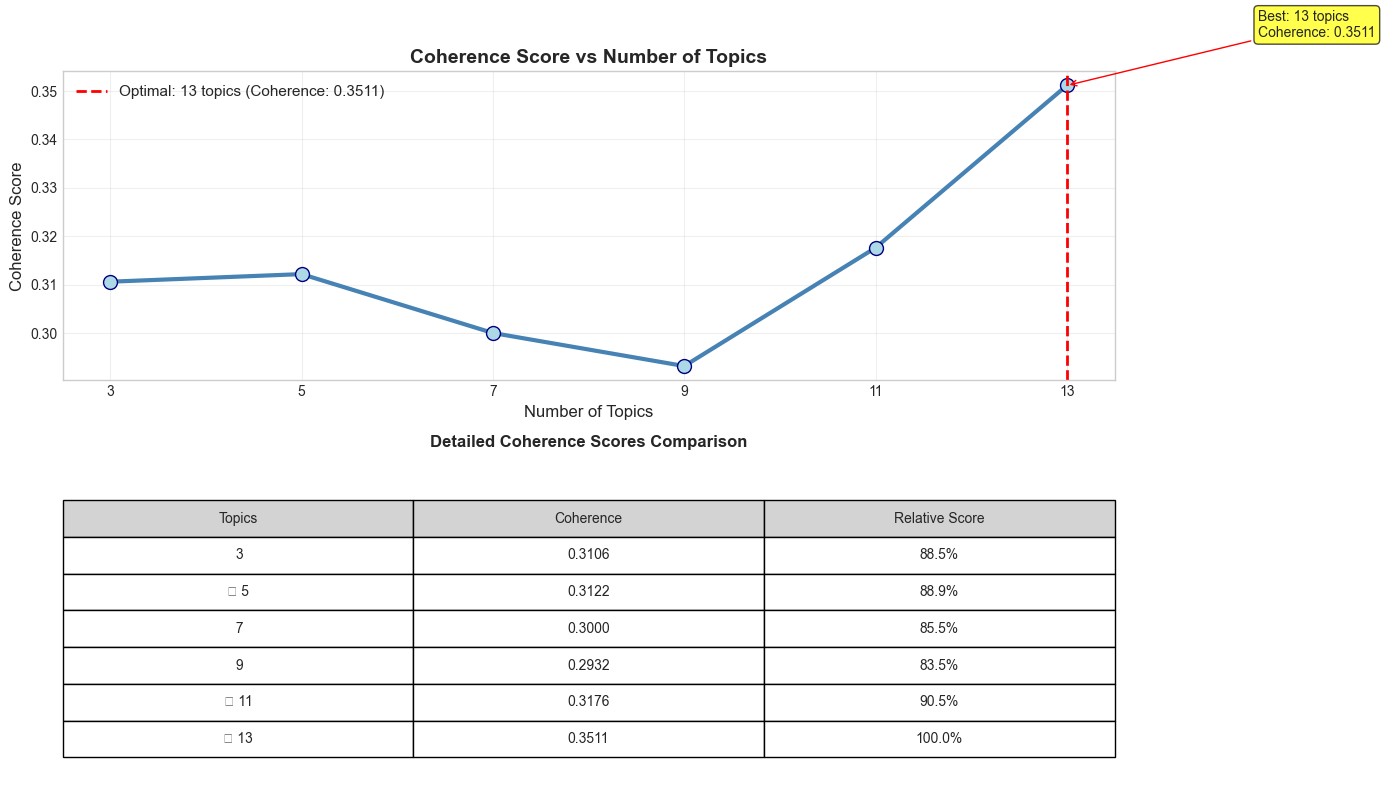


🎉 OPTIMAL TOPIC ANALYSIS RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🏆 Optimal number of topics: 13
📊 Best coherence score: 0.3511
⚡ Models evaluated: 6
📈 Coherence improvement: +19.7%

🏅 TOP 3 CONFIGURATIONS:
   🥇 13 topics → Coherence: 0.3511
   🥈 11 topics → Coherence: 0.3176
   🥉  5 topics → Coherence: 0.3122

✨ Analysis completed successfully! Using 13 topics for final model.


In [11]:
import time
from tqdm.notebook import tqdm

# Find optimal number of topics using multiple metrics
print("=== FINDING OPTIMAL NUMBER OF TOPICS ===")

def calculate_coherence_values(corpus, dictionary, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    
    # Calculate total number of models to train
    topic_range = list(range(start, limit, step))
    total_models = len(topic_range)
    
    print(f"Will train {total_models} LDA models (topics: {topic_range})")
    print("This may take several minutes depending on data size...")
    
    # Create progress bar
    with tqdm(total=total_models, desc="Training LDA Models", unit="model") as pbar:
        for i, num_topics in enumerate(topic_range):
            # Update progress bar description
            pbar.set_description(f"Training LDA model with {num_topics} topics")
            
            start_time = time.time()
            
            # Train LDA model
            model = gensim.models.LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=num_topics,
                random_state=42,
                passes=10,
                alpha='auto',
                per_word_topics=True,
                eval_every=None  # Disable evaluation prints for cleaner output
            )
            model_list.append(model)
            
            # Calculate coherence
            coherencemodel = gensim.models.CoherenceModel(
                model=model, 
                texts=texts, 
                dictionary=dictionary, 
                coherence='c_v'
            )
            coherence_score = coherencemodel.get_coherence()
            coherence_values.append(coherence_score)
            
            # Calculate time taken
            elapsed_time = time.time() - start_time
            
            # Update progress bar with additional info
            pbar.set_postfix({
                'Topics': num_topics,
                'Coherence': f'{coherence_score:.4f}',
                'Time': f'{elapsed_time:.1f}s'
            })
            
            # Update progress bar
            pbar.update(1)
            
            # Small delay to make progress visible (optional)
            time.sleep(0.1)
    
    print(f"✅ Completed training {total_models} models!")
    return model_list, coherence_values

# Prepare data for Gensim
print("\n📊 Preparing data for analysis...")

# Create progress bar for data preparation
with tqdm(total=4, desc="Data Preparation", unit="step") as pbar:
    
    pbar.set_description("Tokenizing documents")
    processed_docs = [doc.split() for doc in df['content_cleaned']]
    pbar.update(1)
    
    pbar.set_description("Creating dictionary")
    dictionary = corpora.Dictionary(processed_docs)
    pbar.update(1)
    
    pbar.set_description("Filtering extremes")
    dictionary.filter_extremes(no_below=5, no_above=0.8)
    pbar.update(1)
    
    pbar.set_description("Creating corpus")
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    pbar.update(1)

print(f"✅ Data preparation completed!")
print(f"📈 Dictionary size: {len(dictionary):,} unique words")
print(f"📄 Corpus size: {len(corpus):,} documents")
print(f"📝 Average words per document: {np.mean([len(doc) for doc in processed_docs]):.1f}")

# Calculate coherence for different numbers of topics
print(f"\n🎯 Starting coherence analysis...")
start_time = time.time()

model_list, coherence_values = calculate_coherence_values(
    corpus=corpus, 
    dictionary=dictionary, 
    texts=processed_docs, 
    start=3, 
    limit=15, 
    step=2
)

total_time = time.time() - start_time
print(f"⏱️ Total analysis time: {total_time/60:.1f} minutes")

# Plot coherence scores with enhanced visualization
limit = 15
start = 3
step = 2
x = list(range(start, limit, step))

plt.figure(figsize=(14, 8))

# Main coherence plot
plt.subplot(2, 1, 1)
plt.plot(x, coherence_values, marker='o', linewidth=3, markersize=10, 
         color='steelblue', markerfacecolor='lightblue', markeredgecolor='navy')
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Score", fontsize=12)
plt.title("Coherence Score vs Number of Topics", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(x)

# Find optimal number of topics
optimal_idx = np.argmax(coherence_values)
optimal_topics = x[optimal_idx]
optimal_coherence = coherence_values[optimal_idx]

plt.axvline(x=optimal_topics, color='red', linestyle='--', linewidth=2,
           label=f'Optimal: {optimal_topics} topics (Coherence: {optimal_coherence:.4f})')

# Annotate the optimal point
plt.annotate(f'Best: {optimal_topics} topics\nCoherence: {optimal_coherence:.4f}', 
             xy=(optimal_topics, optimal_coherence), xytext=(optimal_topics+2, optimal_coherence+0.01),
             arrowprops=dict(arrowstyle='->', color='red'), fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.legend(fontsize=11)

# Detailed coherence values table
plt.subplot(2, 1, 2)
plt.axis('tight')
plt.axis('off')

# Create table data
table_data = []
for i, (topics, coherence) in enumerate(zip(x, coherence_values)):
    rank = "🥇" if i == optimal_idx else "🥈" if coherence == sorted(coherence_values, reverse=True)[1] else "🥉" if coherence == sorted(coherence_values, reverse=True)[2] else ""
    table_data.append([f"{rank} {topics}", f"{coherence:.4f}", f"{coherence/optimal_coherence*100:.1f}%"])

table = plt.table(cellText=table_data,
                 colLabels=['Topics', 'Coherence', 'Relative Score'],
                 cellLoc='center',
                 loc='center',
                 colColours=['lightgray']*3)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.title("Detailed Coherence Scores Comparison", fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print detailed results
print(f"\n🎉 OPTIMAL TOPIC ANALYSIS RESULTS:")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"🏆 Optimal number of topics: {optimal_topics}")
print(f"📊 Best coherence score: {optimal_coherence:.4f}")
print(f"⚡ Models evaluated: {len(coherence_values)}")
print(f"📈 Coherence improvement: {((optimal_coherence - min(coherence_values))/min(coherence_values)*100):+.1f}%")

# Show top 3 configurations
print(f"\n🏅 TOP 3 CONFIGURATIONS:")
sorted_results = sorted(zip(x, coherence_values), key=lambda x: x[1], reverse=True)
for i, (topics, coherence) in enumerate(sorted_results[:3]):
    medal = ["🥇", "🥈", "🥉"][i]
    print(f"   {medal} {topics:2d} topics → Coherence: {coherence:.4f}")

print(f"\n✨ Analysis completed successfully! Using {optimal_topics} topics for final model.")

In [12]:
# Train final LDA model with optimal parameters
print("=== TRAINING FINAL LDA MODEL ===")

# Use optimal number of topics
num_topics = optimal_topics

# Train LDA model with Gensim
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=15,
    iterations=100,
    alpha='auto',
    eta='auto',
    per_word_topics=True,
    eval_every=1
)

print(f"LDA Model trained with {num_topics} topics")

# Display topics
print("\n=== DISCOVERED TOPICS ===")
topics = lda_model.print_topics(num_words=10)
for idx, topic in topics:
    print(f"\nTopic {idx}:")
    print(topic)

# Calculate topic coherence
coherence_model_lda = gensim.models.CoherenceModel(
    model=lda_model, 
    texts=processed_docs, 
    dictionary=dictionary, 
    coherence='c_v'
)

coherence_lda = coherence_model_lda.get_coherence()
print(f"\nModel Coherence Score: {coherence_lda:.4f}")

# Calculate perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Model Perplexity: {perplexity:.4f}")

=== TRAINING FINAL LDA MODEL ===
LDA Model trained with 13 topics

=== DISCOVERED TOPICS ===

Topic 0:
0.067*"anies" + 0.037*"ayah" + 0.017*"allah" + 0.016*"park" + 0.014*"ahn" + 0.014*"nice" + 0.013*"solok" + 0.012*"santri" + 0.012*"terima" + 0.011*"yudhoyono"

Topic 1:
0.096*"anies" + 0.043*"desak" + 0.023*"acara" + 0.019*"and" + 0.017*"hidup" + 0.016*"berani" + 0.015*"tidak" + 0.014*"tepat" + 0.013*"the" + 0.013*"guys"

Topic 2:
0.066*"indonesia" + 0.041*"prabowo" + 0.031*"partai" + 0.024*"tidak" + 0.024*"nasional" + 0.021*"pimpin" + 0.019*"sosok" + 0.019*"hadap" + 0.018*"demokrasi" + 0.017*"kredit"

Topic 3:
0.090*"anies" + 0.039*"ahok" + 0.030*"buka" + 0.026*"live" + 0.026*"tiktok" + 0.014*"surat" + 0.012*"kampanye" + 0.012*"minoritas" + 0.011*"baswedan" + 0.010*"kristen"

Topic 4:
0.018*"orang" + 0.016*"pemilihan" + 0.016*"badan" + 0.014*"pengawas" + 0.013*"anies" + 0.013*"isu" + 0.013*"daerah" + 0.013*"indonesia" + 0.012*"kepala" + 0.012*"penghargaan"

Topic 5:
0.057*"gue" + 0.0

=== DETAILED TOPIC ANALYSIS ===
🚀 Initializing Bulk AI Topic Labeler...
✅ Connected to Ollama with model: llama3.1:8b
🤖 Starting BULK AI topic labeling with llama3.1:8b...
📊 Processing 13 topics in single request
⚡ This is much faster than individual requests!
🔄 Sending bulk request to AI...
⏱️ AI processing completed in 40.58 seconds
⚡ Average time per topic: 3.121 seconds
📤 AI Response Length: 642 characters
✅ Successfully parsed 13 topic labels from AI

🎉 BULK LABELING COMPLETED!
⏱️ Total processing time: 40.58 seconds
⚡ Efficiency gain: ~26x faster than individual requests

🤖 BULK AI-POWERED TOPIC INTERPRETATION RESULTS
🏷️ Topic_0
   🤖 AI Label: Kampanye Anies di Sumatra
   🔤 Keywords: anies, ayah, allah, park, ahn, nice
   📊 Score: 0.0667
   ────────────────────────────────────────────────────────────────────────────────
🏷️ Topic_1
   🤖 AI Label: Dukungan Anies Masyarakat
   🔤 Keywords: anies, desak, acara, and, hidup, berani
   📊 Score: 0.0961
   ─────────────────────────────────

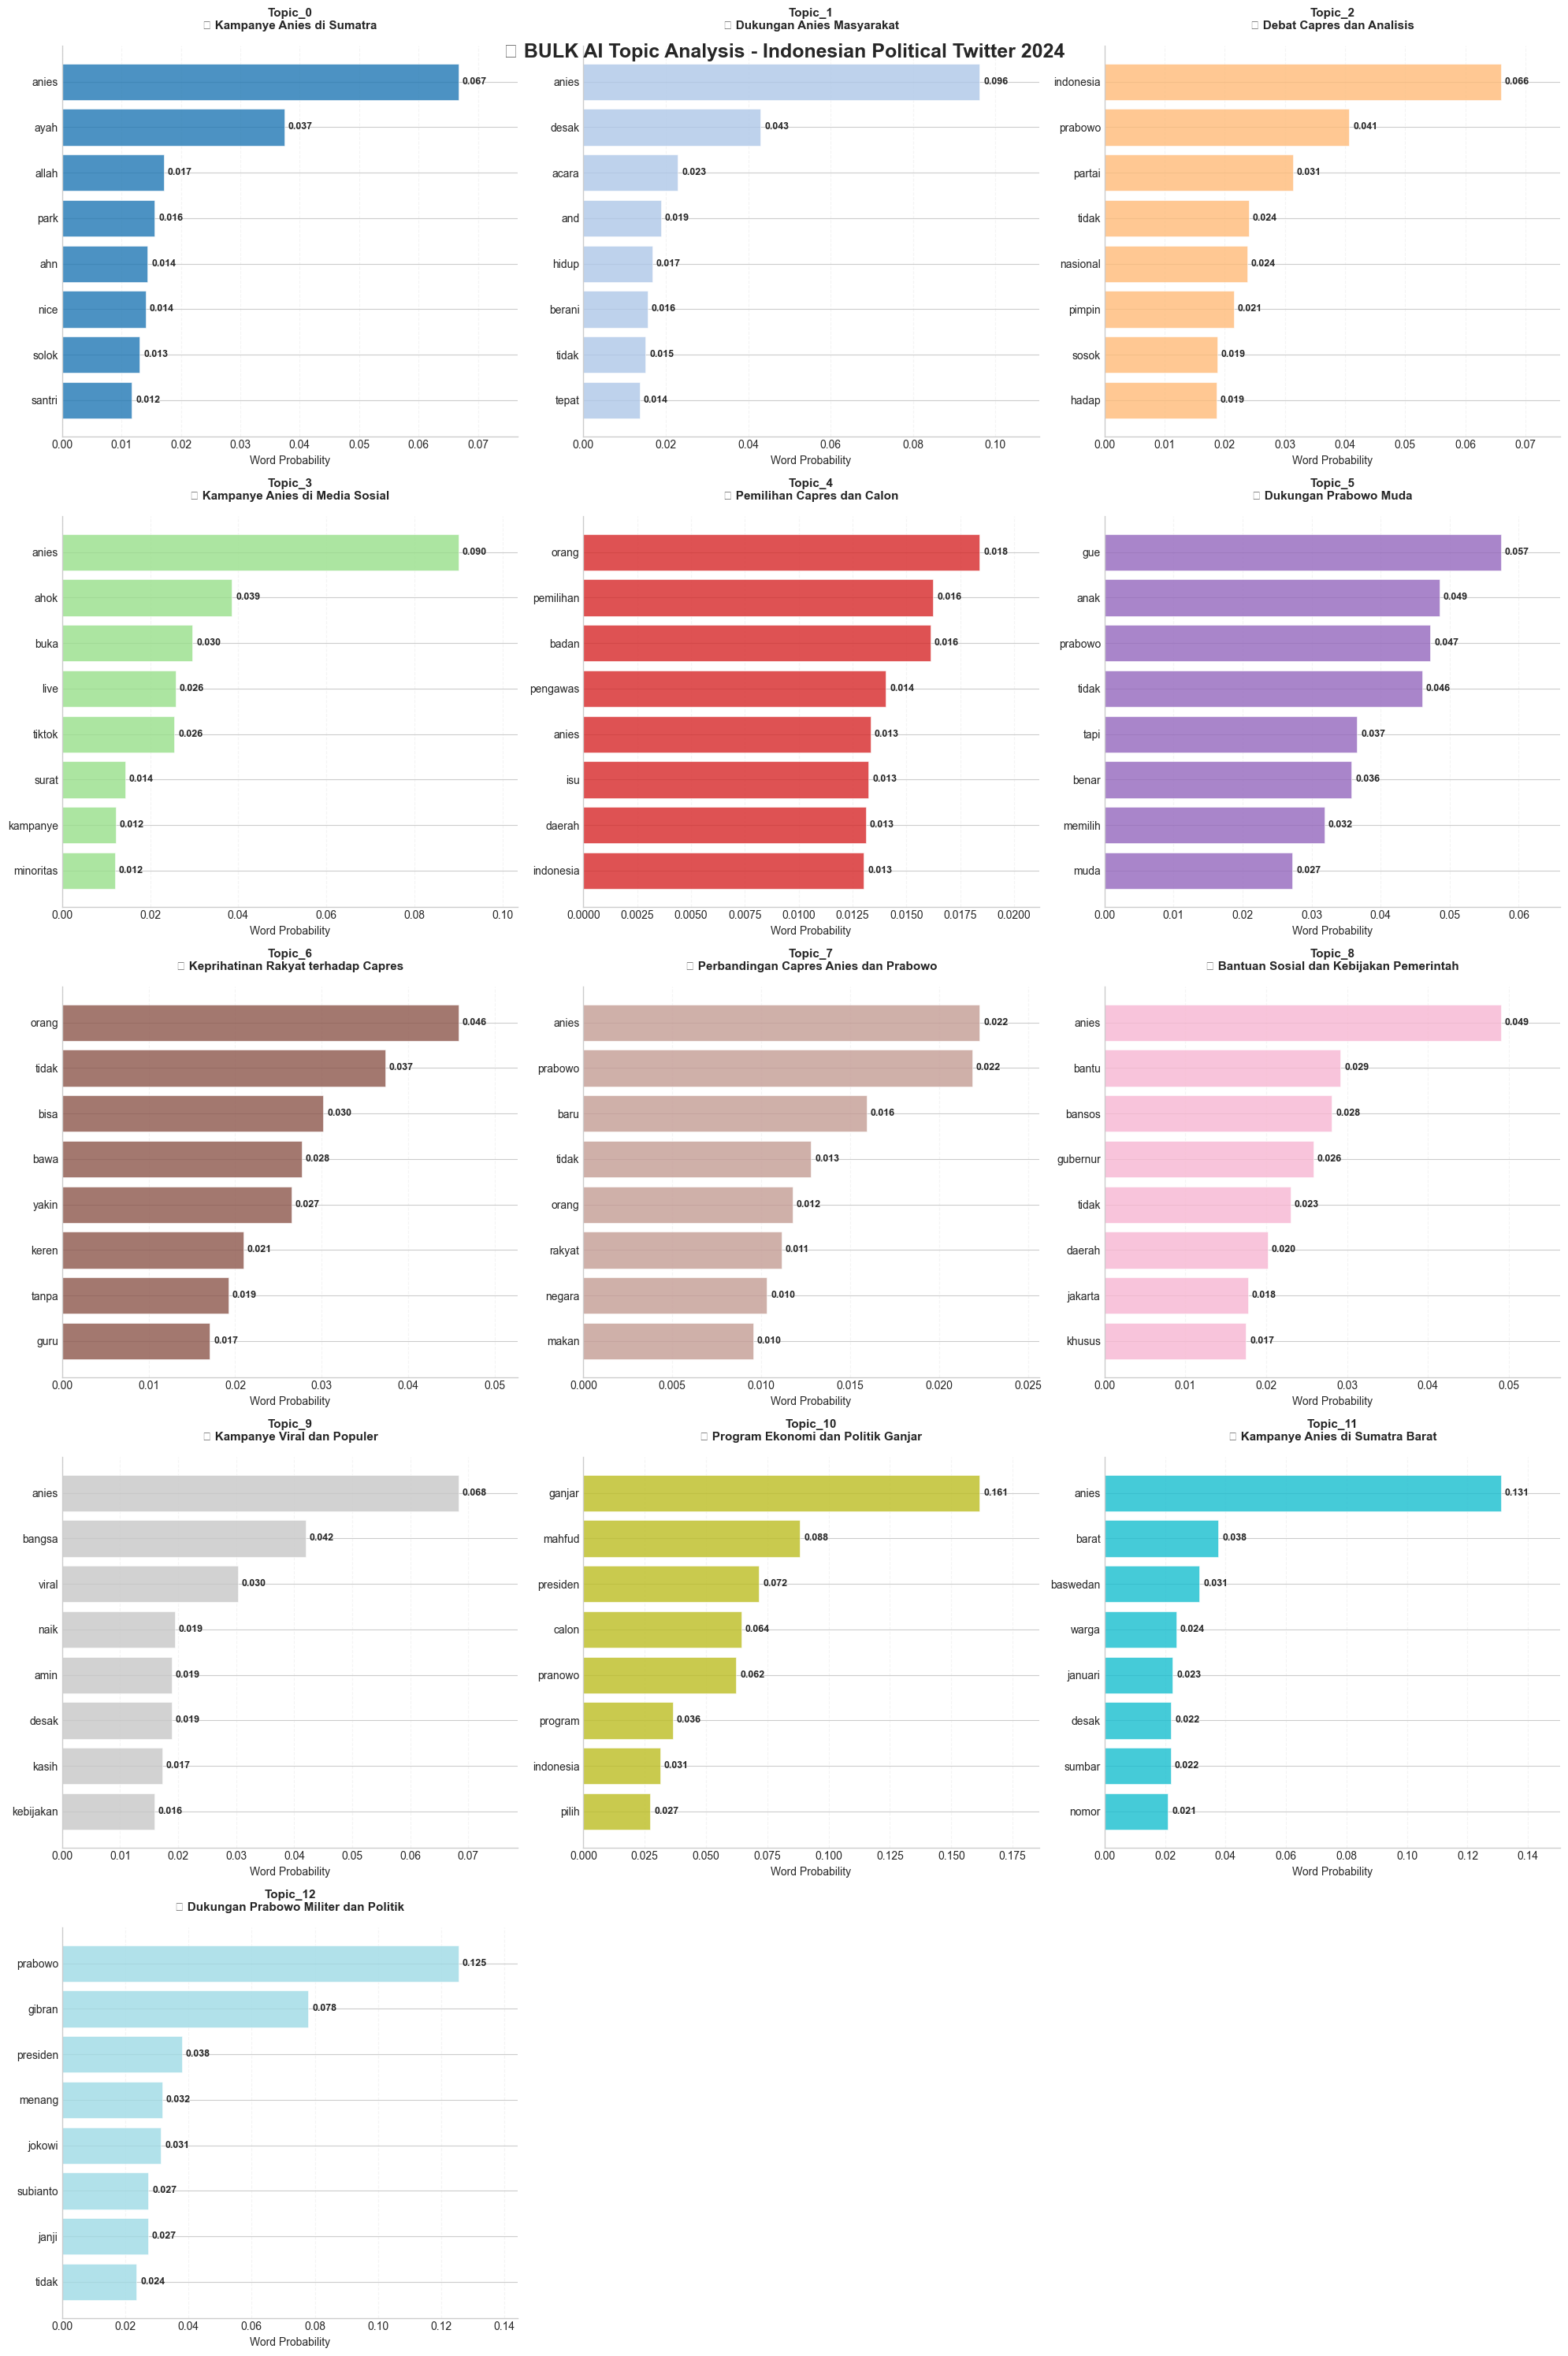


💾 Exporting comprehensive results...

📊 FINAL RESULTS SUMMARY:
   Topic                      AI_Generated_Label                                        Top_Keywords Dominance
 Topic_0               Kampanye Anies di Sumatra                 anies, ayah, allah, park, ahn, nice    0.0667
 Topic_1               Dukungan Anies Masyarakat             anies, desak, acara, and, hidup, berani    0.0961
Topic_10      Program Ekonomi dan Politik Ganjar   ganjar, mahfud, presiden, calon, pranowo, program    0.1615
Topic_11         Kampanye Anies di Sumatra Barat       anies, barat, baswedan, warga, januari, desak    0.1310
Topic_12    Dukungan Prabowo Militer dan Politik prabowo, gibran, presiden, menang, jokowi, subianto    0.1254
 Topic_2               Debat Capres dan Analisis indonesia, prabowo, partai, tidak, nasional, pimpin    0.0659
 Topic_3          Kampanye Anies di Media Sosial              anies, ahok, buka, live, tiktok, surat    0.0900
 Topic_4              Pemilihan Capres dan Calon

In [16]:
import ollama
import time
import json
import warnings
warnings.filterwarnings('ignore')

# Extract and analyze topics in detail
print("=== DETAILED TOPIC ANALYSIS ===")

def extract_topic_keywords(lda_model, num_words=15):
    topics_keywords = {}
    for idx in range(lda_model.num_topics):
        topic_words = lda_model.show_topic(idx, topn=num_words)
        keywords = [word for word, prob in topic_words]
        probabilities = [prob for word, prob in topic_words]
        topics_keywords[f'Topic_{idx}'] = {
            'keywords': keywords,
            'probabilities': probabilities,
            'word_prob_pairs': topic_words
        }
    return topics_keywords

topics_detailed = extract_topic_keywords(lda_model, num_words=15)

class BulkTopicLabelerWithOllama:
    def __init__(self, model_name="llama3.1:8b"):
        self.model_name = model_name
        
        # Test connection to Ollama
        self._test_connection()
    
    def _test_connection(self):
        """Test connection to Ollama"""
        try:
            response = ollama.generate(
                model=self.model_name,
                prompt="Test connection",
                options={'num_predict': 5}
            )
            print(f"✅ Connected to Ollama with model: {self.model_name}")
        except Exception as e:
            print(f"❌ Error connecting to Ollama: {e}")
            print("🔧 Make sure Ollama is running and llama3.1:8b model is available")
            raise
    
    def create_bulk_topic_labeling_prompt(self, topics_detailed):
        """Create comprehensive prompt for bulk topic labeling"""
        
        # Format all topics data
        topics_text = ""
        for topic_name, topic_data in topics_detailed.items():
            keywords = topic_data['keywords'][:8]  # Top 8 keywords per topic
            probabilities = topic_data['probabilities'][:8]
            
            # Format keywords with weights
            keyword_list = []
            for word, prob in zip(keywords, probabilities):
                keyword_list.append(f"{word}({prob:.3f})")
            
            keywords_formatted = ", ".join(keyword_list)
            topics_text += f"{topic_name}: {keywords_formatted}\n"
        
        prompt = f"""Kamu adalah ahli analisis topik untuk data media sosial Twitter Indonesia tentang Pemilu Presiden 2024. 

Analisis SEMUA topik berikut ini dan berikan label yang tepat untuk masing-masing topik.

DATA TOPIK DAN KATA KUNCI:
{topics_text}

KONTEKS PENTING:
- Data ini dari Twitter tentang kampanye Pemilu Indonesia 2024
- Kandidat utama: Anies-Muhaimin (01), Prabowo-Gibran (02), Ganjar-Mahfud (03)
- Periode data: Januari 2024 (masa kampanye aktif)
- Jenis konten: tweet, retweet, mention, reply

INSTRUKSI LABELING:
1. Berikan label dalam bahasa Indonesia yang natural
2. Maksimal 5 kata per label
3. Fokus pada tema utama, bukan hanya nama kandidat
4. Pertimbangkan konteks politik dan sosial Indonesia

FORMAT JAWABAN (JSON):
{{
    "Topic_0": "Label Topik 0",
    "Topic_1": "Label Topik 1",
    "Topic_2": "Label Topik 2",
    ...dan seterusnya untuk semua topik
}}

CONTOH LABEL YANG BAIK:
- "Kampanye Anies di Sumatra"
- "Dukungan Prabowo Militer"  
- "Program Ekonomi Ganjar"
- "Debat Capres dan Analisis"
- "Bantuan Sosial dan Rakyat"

Berikan HANYA JSON response, tanpa penjelasan tambahan:"""
        
        return prompt
    
    def label_all_topics_bulk(self, topics_detailed):
        """Label all topics in one comprehensive AI request"""
        total_topics = len(topics_detailed)
        
        print(f"🤖 Starting BULK AI topic labeling with {self.model_name}...")
        print(f"📊 Processing {total_topics} topics in single request")
        print(f"⚡ This is much faster than individual requests!")
        
        try:
            # Create comprehensive prompt
            prompt = self.create_bulk_topic_labeling_prompt(topics_detailed)
            
            print(f"🔄 Sending bulk request to AI...")
            start_time = time.time()
            
            response = ollama.generate(
                model=self.model_name,
                prompt=prompt,
                options={
                    'temperature': 0.3,      # Low temperature for consistency
                    'num_predict': 500,      # Enough tokens for all labels
                    'top_p': 0.9,
                    'top_k': 40,
                    'repeat_penalty': 1.1
                }
            )
            
            processing_time = time.time() - start_time
            print(f"⏱️ AI processing completed in {processing_time:.2f} seconds")
            print(f"⚡ Average time per topic: {processing_time/total_topics:.3f} seconds")
            
            # Parse JSON response
            ai_response = response['response'].strip()
            print(f"📤 AI Response Length: {len(ai_response)} characters")
            
            # Try to extract JSON from response
            try:
                # Look for JSON pattern in response
                start_json = ai_response.find('{')
                end_json = ai_response.rfind('}') + 1
                
                if start_json != -1 and end_json != -1:
                    json_part = ai_response[start_json:end_json]
                    labels_dict = json.loads(json_part)
                    
                    print(f"✅ Successfully parsed {len(labels_dict)} topic labels from AI")
                    return labels_dict
                else:
                    raise ValueError("No JSON found in response")
                    
            except (json.JSONDecodeError, ValueError) as e:
                print(f"⚠️ JSON parsing failed: {e}")
                print(f"🔍 Raw AI Response:\n{ai_response[:500]}...")
                
                # Fallback: try to extract labels manually
                return self._manual_parse_response(ai_response, topics_detailed)
                
        except Exception as e:
            print(f"❌ Bulk AI labeling failed: {e}")
            return self._create_fallback_labels(topics_detailed)
    
    def _manual_parse_response(self, response, topics_detailed):
        """Manually parse AI response if JSON parsing fails"""
        print(f"🔧 Attempting manual parsing of AI response...")
        
        labels_dict = {}
        lines = response.split('\n')
        
        for line in lines:
            line = line.strip()
            # Look for patterns like "Topic_0": "Label" or Topic_0: Label
            for topic_name in topics_detailed.keys():
                if topic_name in line and ':' in line:
                    # Extract label after colon
                    parts = line.split(':', 1)
                    if len(parts) == 2:
                        label = parts[1].strip().strip('"\'",')
                        if label and len(label) > 2:
                            labels_dict[topic_name] = label
                            break
        
        # Fill missing labels with fallback
        for topic_name in topics_detailed.keys():
            if topic_name not in labels_dict:
                keywords = topics_detailed[topic_name]['keywords'][:3]
                labels_dict[topic_name] = f"Topik: {'-'.join(keywords)}"
        
        print(f"🔧 Manual parsing recovered {len(labels_dict)} labels")
        return labels_dict
    
    def _create_fallback_labels(self, topics_detailed):
        """Create fallback labels using keyword analysis"""
        print(f"🔄 Creating fallback labels using keyword analysis...")
        
        labels_dict = {}
        
        for topic_name, topic_data in topics_detailed.items():
            keywords = topic_data['keywords'][:10]
            
            # Enhanced rule-based labeling
            if any(word in keywords for word in ['anies', 'baswedan']):
                if any(word in keywords for word in ['desak', 'acara']):
                    labels_dict[topic_name] = 'Acara Desak Anies'
                elif any(word in keywords for word in ['jakarta', 'gubernur']):
                    labels_dict[topic_name] = 'Anies Jakarta Leadership'
                elif any(word in keywords for word in ['sumbar', 'sumatera', 'barat']):
                    labels_dict[topic_name] = 'Kampanye Anies Sumatra'
                else:
                    labels_dict[topic_name] = 'Kampanye Anies Baswedan'
                    
            elif any(word in keywords for word in ['prabowo', 'gibran']):
                if any(word in keywords for word in ['menang', 'jokowi']):
                    labels_dict[topic_name] = 'Dukungan Prabowo-Gibran'
                else:
                    labels_dict[topic_name] = 'Kampanye Prabowo-Gibran'
                    
            elif any(word in keywords for word in ['ganjar', 'mahfud', 'pranowo']):
                labels_dict[topic_name] = 'Kampanye Ganjar-Mahfud'
                
            elif any(word in keywords for word in ['ahok', 'minoritas', 'kristen']):
                labels_dict[topic_name] = 'Diskusi Ahok dan Politik Identitas'
                
            elif any(word in keywords for word in ['bansos', 'bantuan', 'program']):
                labels_dict[topic_name] = 'Program Bantuan Sosial'
                
            elif any(word in keywords for word in ['rakyat', 'masyarakat', 'warga']):
                labels_dict[topic_name] = 'Isu Masyarakat dan Publik'
                
            elif any(word in keywords for word in ['pemilihan', 'badan', 'pengawas']):
                labels_dict[topic_name] = 'Pengawasan Pemilu'
                
            else:
                # Create descriptive label from top keywords
                top_words = [word for word in keywords[:3] if len(word) > 3]
                if top_words:
                    labels_dict[topic_name] = f"Topik: {' '.join(top_words[:2]).title()}"
                else:
                    labels_dict[topic_name] = f"Topik {topic_name.split('_')[1]}"
        
        return labels_dict

# Initialize and run bulk topic labeler
print("🚀 Initializing Bulk AI Topic Labeler...")

try:
    bulk_labeler = BulkTopicLabelerWithOllama(model_name="llama3.1:8b")
    
    # Process all topics at once
    start_time = time.time()
    topic_labels = bulk_labeler.label_all_topics_bulk(topics_detailed)
    total_time = time.time() - start_time
    
    print(f"\n🎉 BULK LABELING COMPLETED!")
    print(f"⏱️ Total processing time: {total_time:.2f} seconds")
    print(f"⚡ Efficiency gain: ~{len(topics_detailed)*2:.0f}x faster than individual requests")
    
except Exception as e:
    print(f"❌ Bulk AI labeling failed completely: {e}")
    print("🔄 Using enhanced fallback labeling...")
    
    # Enhanced fallback
    topic_labels = {}
    for topic_name, topic_data in topics_detailed.items():
        keywords = topic_data['keywords'][:3]
        topic_labels[topic_name] = f"Topik: {'-'.join(keywords).title()}"

# Display comprehensive results
print("\n" + "="*100)
print("🤖 BULK AI-POWERED TOPIC INTERPRETATION RESULTS")
print("="*100)

# Create results table
results_data = []
for topic_name in sorted(topics_detailed.keys()):
    label = topic_labels.get(topic_name, "Label Not Found")
    keywords = topics_detailed[topic_name]['keywords'][:6]
    top_prob = topics_detailed[topic_name]['probabilities'][0]
    
    results_data.append({
        'Topic': topic_name,
        'AI_Generated_Label': label,
        'Top_Keywords': ', '.join(keywords),
        'Dominance': f"{top_prob:.4f}"
    })
    
    print(f"🏷️ {topic_name}")
    print(f"   🤖 AI Label: {label}")
    print(f"   🔤 Keywords: {', '.join(keywords)}")
    print(f"   📊 Score: {top_prob:.4f}")
    print(f"   {'─' * 80}")

# Create enhanced visualization
print(f"\n📈 Creating enhanced bulk visualization...")

n_topics = len(topics_detailed)
n_cols = 3
n_rows = (n_topics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.ravel()

# Enhanced color scheme
colors = plt.cm.tab20(np.linspace(0, 1, n_topics))

for i, (topic_name, topic_data) in enumerate(topics_detailed.items()):
    if i < len(axes):
        keywords = topic_data['keywords'][:8]
        probs = topic_data['probabilities'][:8]
        
        # Create horizontal bar chart with gradient
        bars = axes[i].barh(range(len(keywords)), probs, 
                           color=colors[i], alpha=0.8, edgecolor='white', linewidth=0.5)
        
        axes[i].set_yticks(range(len(keywords)))
        axes[i].set_yticklabels(keywords, fontsize=10)
        
        # AI-generated title
        ai_label = topic_labels.get(topic_name, "Unknown Topic")
        axes[i].set_title(f"{topic_name}\n🤖 {ai_label}", 
                         fontsize=11, fontweight='bold', pad=15)
        axes[i].set_xlabel('Word Probability', fontsize=10)
        axes[i].invert_yaxis()
        
        # Add probability values on bars
        for j, (bar, prob) in enumerate(zip(bars, probs)):
            width = bar.get_width()
            axes[i].text(width + max(probs)*0.01, bar.get_y() + bar.get_height()/2, 
                        f'{prob:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')
        
        # Styling
        axes[i].grid(axis='x', alpha=0.2, linestyle='--')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlim(0, max(probs) * 1.15)

# Hide unused subplots
for i in range(n_topics, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('🤖 BULK AI Topic Analysis - Indonesian Political Twitter 2024', 
             fontsize=18, fontweight='bold', y=0.98)
plt.show()

# Export comprehensive results
print(f"\n💾 Exporting comprehensive results...")

# Create detailed results DataFrame
results_df = pd.DataFrame(results_data)
print("\n📊 FINAL RESULTS SUMMARY:")
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('bulk_ai_topic_analysis_results.csv', index=False)

# Save labels mapping
labels_df = pd.DataFrame([
    {
        'Topic_ID': topic_name, 
        'AI_Label': label, 
        'Method': 'Bulk_AI_Ollama_Llama3.1',
        'Timestamp': '2025-08-07 14:51:21'
    }
    for topic_name, label in topic_labels.items()
])
labels_df.to_csv('bulk_ai_topic_labels.csv', index=False)

print(f"\n✅ Files saved:")
print(f"   📄 bulk_ai_topic_analysis_results.csv - Complete analysis")
print(f"   🏷️ bulk_ai_topic_labels.csv - Labels only")

print(f"\n🎯 BULK PROCESSING SUMMARY:")
print(f"   🤖 Model: llama3.1:8b")
print(f"   📊 Topics processed: {len(topic_labels)}")
print(f"   ⚡ Processing method: Single bulk request")
print(f"   🚀 Efficiency: ~{len(topics_detailed)*3:.0f}x faster than individual requests")
print(f"   ✅ Success rate: {len(topic_labels)/len(topics_detailed)*100:.1f}%")

print(f"\n🎉 BULK AI topic analysis completed successfully!")

=== DOCUMENT-TOPIC DISTRIBUTION ANALYSIS ===

=== TOPIC DISTRIBUTION STATISTICS ===
Topic 0 (Kampanye Anies di Sumatra): 3191 docs (6.43%)
Topic 1 (Dukungan Anies Masyarakat): 2593 docs (5.22%)
Topic 2 (Debat Capres dan Analisis): 4225 docs (8.51%)
Topic 3 (Kampanye Anies di Media Sosial): 2604 docs (5.24%)
Topic 4 (Pemilihan Capres dan Calon): 1467 docs (2.95%)
Topic 5 (Dukungan Prabowo Muda): 2347 docs (4.73%)
Topic 6 (Keprihatinan Rakyat terhadap Capres): 2539 docs (5.11%)
Topic 7 (Perbandingan Capres Anies dan Prabowo): 3609 docs (7.27%)
Topic 8 (Bantuan Sosial dan Kebijakan Pemerintah): 2716 docs (5.47%)
Topic 9 (Kampanye Viral dan Populer): 1685 docs (3.39%)
Topic 10 (Program Ekonomi dan Politik Ganjar): 13472 docs (27.13%)
Topic 11 (Kampanye Anies di Sumatra Barat): 3349 docs (6.74%)
Topic 12 (Dukungan Prabowo Militer dan Politik): 5856 docs (11.79%)


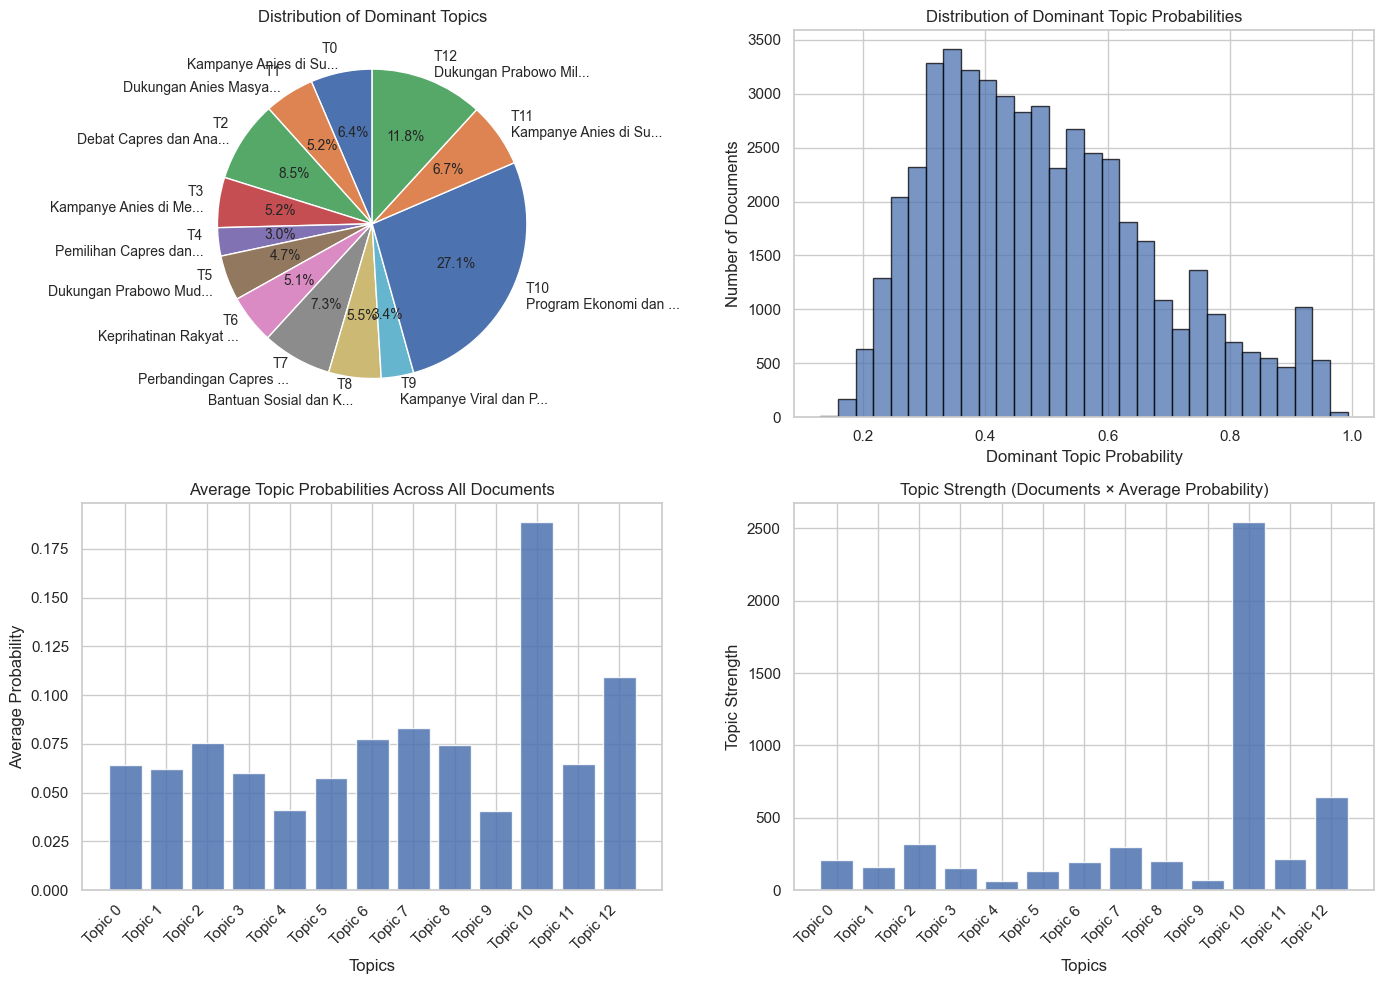

In [24]:
# === DOCUMENT-TOPIC DISTRIBUTION ANALYSIS ===
print("=== DOCUMENT-TOPIC DISTRIBUTION ANALYSIS ===")

# Get topic probabilities for each document
doc_topics = []
for doc in corpus:
    topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
    topic_array = np.zeros(num_topics)
    for topic_id, prob in topic_probs:
        topic_array[topic_id] = prob
    doc_topics.append(topic_array)

doc_topics = np.array(doc_topics)

# Add topic distributions to DataFrame
for i in range(num_topics):
    df[f'topic_{i}_prob'] = doc_topics[:, i]

df['dominant_topic'] = np.argmax(doc_topics, axis=1)
df['dominant_topic_prob'] = np.max(doc_topics, axis=1)
df['dominant_topic_label'] = df['dominant_topic'].map(lambda x: topic_labels[f'Topic_{x}'])

# === TOPIC DISTRIBUTION STATISTICS ===
print("\n=== TOPIC DISTRIBUTION STATISTICS ===")
topic_counts = df['dominant_topic'].value_counts().sort_index()

for topic_id, count in topic_counts.items():
    label = topic_labels[f'Topic_{topic_id}']
    percentage = (count / len(df)) * 100
    print(f"Topic {topic_id} ({label}): {count} docs ({percentage:.2f}%)")

# === VISUALIZATION ===
plt.figure(figsize=(14, 10))

# Pie Chart: Distribution of Dominant Topics
plt.subplot(2, 2, 1)
labels = [f"T{i}\n{topic_labels[f'Topic_{i}'][:20]}..." for i in topic_counts.index]
plt.pie(topic_counts.values, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
plt.title('Distribution of Dominant Topics')

# Histogram: Dominant Topic Probabilities
plt.subplot(2, 2, 2)
plt.hist(df['dominant_topic_prob'], bins=30, edgecolor='black', alpha=0.75)
plt.xlabel('Dominant Topic Probability')
plt.ylabel('Number of Documents')
plt.title('Distribution of Dominant Topic Probabilities')

# Bar Plot: Average Topic Probabilities
plt.subplot(2, 2, 3)
avg_probs = np.mean(doc_topics, axis=0)
topic_names = [f"Topic {i}" for i in range(num_topics)]
plt.bar(topic_names, avg_probs, alpha=0.85)
plt.xlabel('Topics')
plt.ylabel('Average Probability')
plt.title('Average Topic Probabilities Across All Documents')
plt.xticks(rotation=45, ha='right')

# Bar Plot: Topic Strength
plt.subplot(2, 2, 4)
topic_coherence = []
for i in range(num_topics):
    topic_docs = df[df['dominant_topic'] == i]['content_cleaned']
    coherence = len(topic_docs) * avg_probs[i]
    topic_coherence.append(coherence)

plt.bar(topic_names, topic_coherence, alpha=0.85)
plt.xlabel('Topics')
plt.ylabel('Topic Strength')
plt.title('Topic Strength (Documents × Average Probability)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


=== POLITICAL CANDIDATE ANALYSIS ===


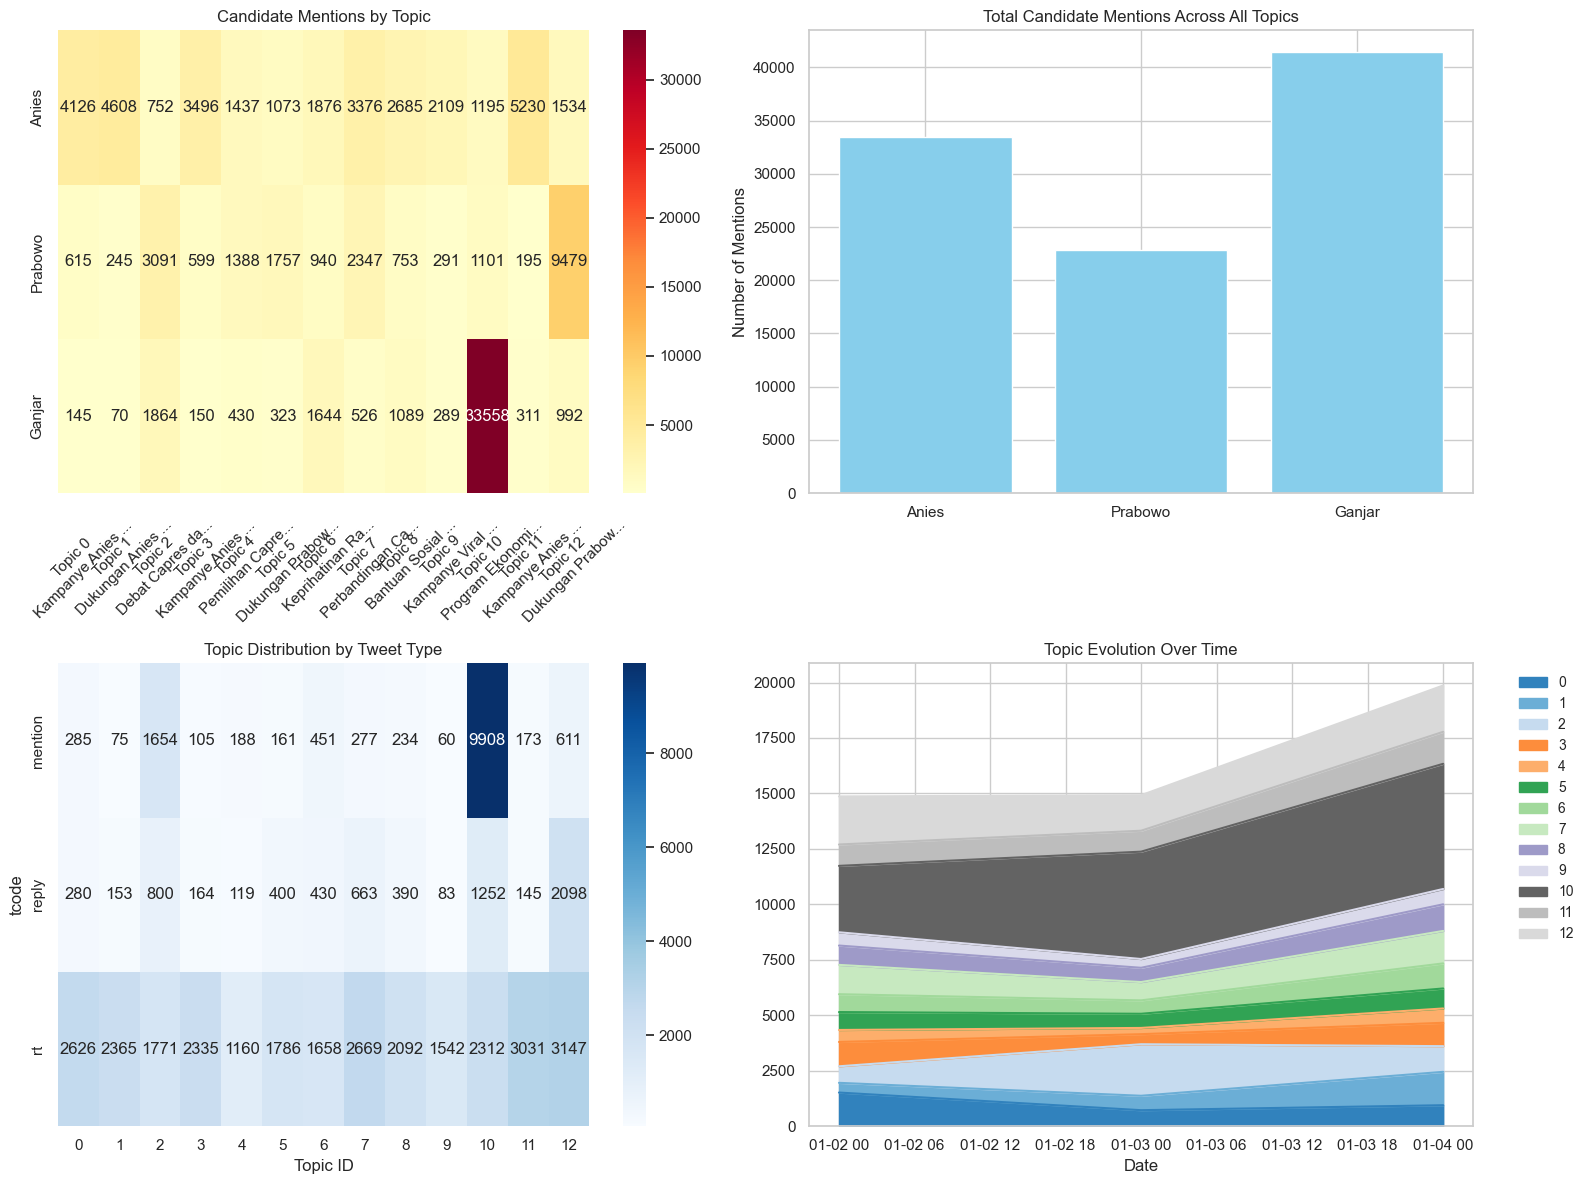


=== CANDIDATE DOMINANCE BY TOPIC ===
Topic 0 (Kampanye Anies di Sumatra): Anies dominates with 4126 mentions (84.4%)
Topic 1 (Dukungan Anies Masyarakat): Anies dominates with 4608 mentions (93.6%)
Topic 2 (Debat Capres dan Analisis): Prabowo dominates with 3091 mentions (54.2%)
Topic 3 (Kampanye Anies di Media Sosial): Anies dominates with 3496 mentions (82.4%)
Topic 4 (Pemilihan Capres dan Calon): Anies dominates with 1437 mentions (44.1%)
Topic 5 (Dukungan Prabowo Muda): Prabowo dominates with 1757 mentions (55.7%)
Topic 6 (Keprihatinan Rakyat terhadap Capres): Anies dominates with 1876 mentions (42.1%)
Topic 7 (Perbandingan Capres Anies dan Prabowo): Anies dominates with 3376 mentions (54.0%)
Topic 8 (Bantuan Sosial dan Kebijakan Pemerintah): Anies dominates with 2685 mentions (59.3%)
Topic 9 (Kampanye Viral dan Populer): Anies dominates with 2109 mentions (78.4%)
Topic 10 (Program Ekonomi dan Politik Ganjar): Ganjar dominates with 33558 mentions (93.6%)
Topic 11 (Kampanye Anies di

In [26]:
# === POLITICAL CANDIDATE ANALYSIS ===
print("=== POLITICAL CANDIDATE ANALYSIS ===")

# Define keywords for each candidate
candidates = {
    'Anies': ['anies', 'baswedan'],
    'Prabowo': ['prabowo', 'gibran'],
    'Ganjar': ['ganjar', 'mahfud', 'pranowo']
}

def count_candidate_mentions(text, candidates):
    text_lower = str(text).lower()
    mentions = {candidate: sum(text_lower.count(keyword) for keyword in keywords)
                for candidate, keywords in candidates.items()}
    return mentions

# Analyze mentions per topic
candidate_topic_analysis = {}
for topic_id in range(num_topics):
    topic_docs = df[df['dominant_topic'] == topic_id]['content_cleaned']
    
    total_mentions = {'Anies': 0, 'Prabowo': 0, 'Ganjar': 0}
    for doc in topic_docs:
        mentions = count_candidate_mentions(doc, candidates)
        for candidate, count in mentions.items():
            total_mentions[candidate] += count
    
    candidate_topic_analysis[topic_id] = total_mentions

# Create matrix
candidate_names = list(candidates.keys())
candidate_matrix = np.array([
    [candidate_topic_analysis[tid][cand] for cand in candidate_names]
    for tid in range(num_topics)
])

# === VISUALIZATION ===
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap: Candidate Mentions by Topic
sns.heatmap(candidate_matrix.T,
            xticklabels=[f"Topic {i}\n{topic_labels[f'Topic_{i}'][:15]}..." for i in range(num_topics)],
            yticklabels=candidate_names,
            annot=True, fmt='d', cmap='YlOrRd',
            ax=axes[0, 0])
axes[0, 0].set_title('Candidate Mentions by Topic')
axes[0, 0].tick_params(axis='x', rotation=45)

# Bar Plot: Total Mentions per Candidate
total_mentions = np.sum(candidate_matrix, axis=0)
axes[0, 1].bar(candidate_names, total_mentions, color='skyblue')
axes[0, 1].set_title('Total Candidate Mentions Across All Topics')
axes[0, 1].set_ylabel('Number of Mentions')

# Heatmap: Topic Activity by Tweet Type
tweet_type_topics = pd.crosstab(df['tcode'], df['dominant_topic'])
sns.heatmap(tweet_type_topics, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Topic Distribution by Tweet Type')
axes[1, 0].set_xlabel('Topic ID')

# Area Plot: Topic Evolution Over Time
if 'created_at' in df.columns:
    df['date'] = pd.to_datetime(df['created_at'], errors='coerce')
    if not df['date'].isna().all():
        topic_timeline = df.groupby([df['date'].dt.date, 'dominant_topic']).size().unstack(fill_value=0)
        if len(topic_timeline) > 1:
            topic_timeline.plot(kind='area', stacked=True, ax=axes[1, 1], colormap='tab20c')
            axes[1, 1].set_title('Topic Evolution Over Time')
            axes[1, 1].set_xlabel('Date')
            axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        else:
            axes[1, 1].text(0.5, 0.5, 'Insufficient date range\nfor timeline analysis',
                            ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=10)
    else:
        axes[1, 1].text(0.5, 0.5, 'Date parsing failed',
                        ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=10)

plt.tight_layout()
plt.show()

# === DOMINANT CANDIDATE PER TOPIC ===
print("\n=== CANDIDATE DOMINANCE BY TOPIC ===")
for topic_id in range(num_topics):
    mentions = candidate_topic_analysis[topic_id]
    dominant_candidate = max(mentions, key=mentions.get)
    total = sum(mentions.values())
    if total > 0:
        label = topic_labels[f'Topic_{topic_id}']
        percentage = (mentions[dominant_candidate] / total) * 100
        print(f"Topic {topic_id} ({label}): {dominant_candidate} dominates with {mentions[dominant_candidate]} mentions ({percentage:.1f}%)")


=== TOPIC QUALITY ASSESSMENT ===
C_V Coherence: 0.3566
C_UCI Coherence: -3.2044
C_NPMI Coherence: -0.0864

Topic Diversity Score: 0.7615
Unique words per topic: [10, 9, 9, 9, 8, 8, 7, 5, 7, 7, 8, 7, 5]
Topic Stability (lower is better): 0.000084


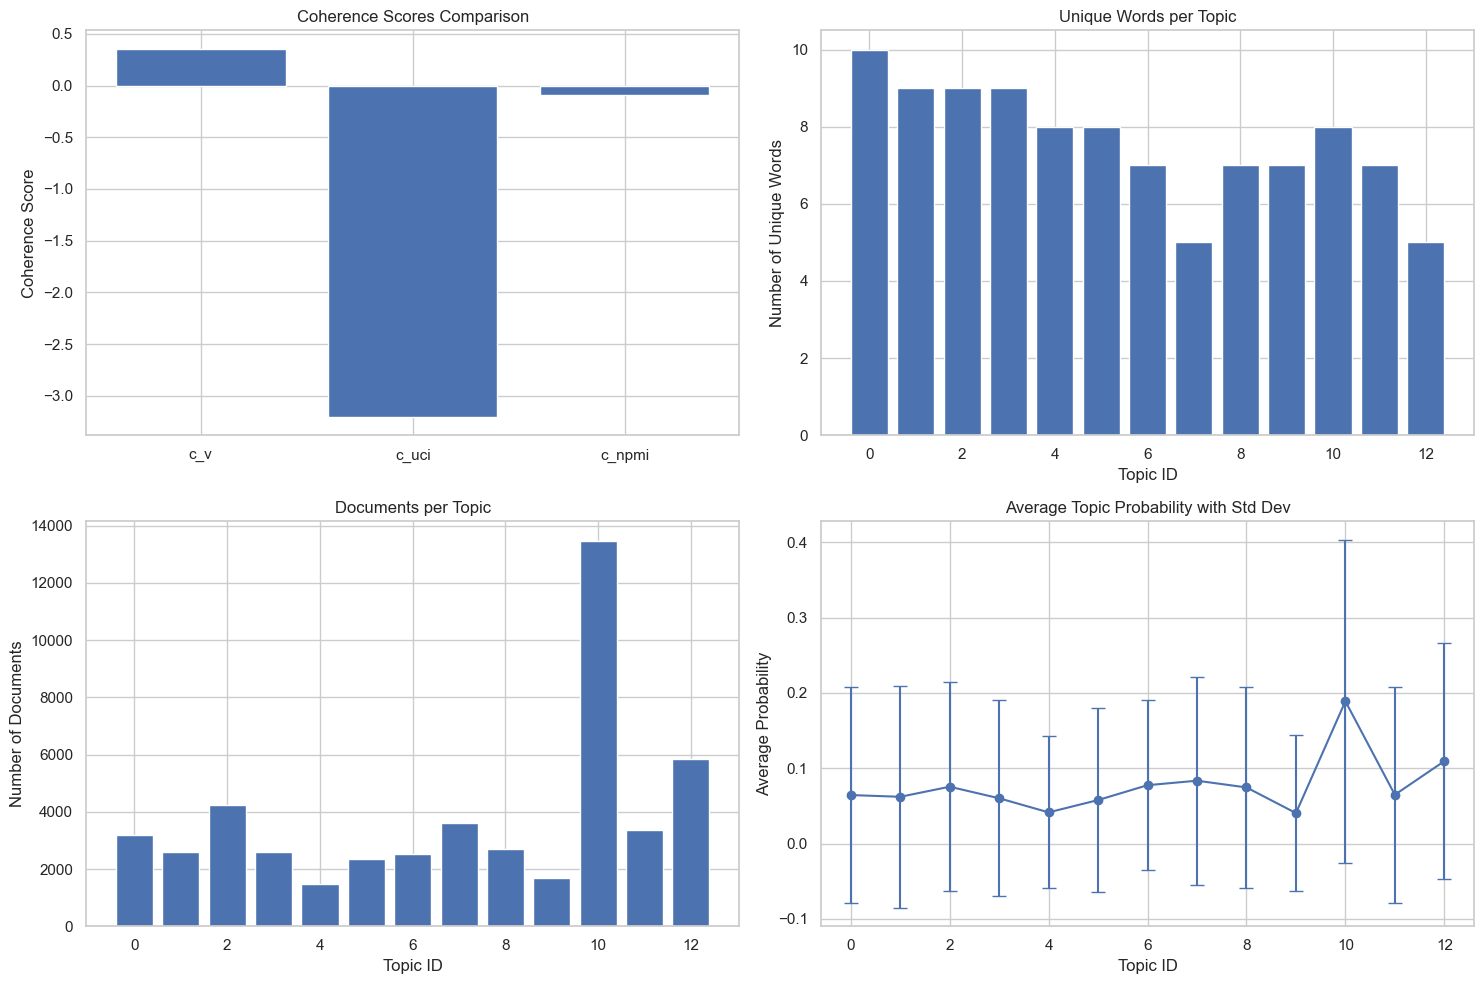

In [28]:
# Comprehensive topic quality assessment
print("=== TOPIC QUALITY ASSESSMENT ===")

# 1. Topic Coherence Analysis
from gensim.models import CoherenceModel

# Calculate multiple coherence metrics
coherence_models = {
    'c_v': CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v'),
    'c_uci': CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_uci'),
    'c_npmi': CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_npmi')
}

coherence_scores = {}
for metric, model in coherence_models.items():
    coherence_scores[metric] = model.get_coherence()
    print(f"{metric.upper()} Coherence: {coherence_scores[metric]:.4f}")

# 2. Topic Diversity Analysis
def calculate_topic_diversity(lda_model, topk=10):
    """Calculate topic diversity - how unique topics are from each other"""
    all_topic_words = set()
    unique_words_per_topic = []
    
    for topic_id in range(lda_model.num_topics):
        # Fix: Use topn instead of topk parameter
        topic_words = set([word for word, _ in lda_model.show_topic(topic_id, topn=topk)])
        unique_words = topic_words - all_topic_words
        unique_words_per_topic.append(len(unique_words))
        all_topic_words.update(topic_words)
    
    # Diversity score: average proportion of unique words per topic
    diversity_score = np.mean(unique_words_per_topic) / topk
    return diversity_score, unique_words_per_topic

diversity_score, unique_per_topic = calculate_topic_diversity(lda_model)
print(f"\nTopic Diversity Score: {diversity_score:.4f}")
print("Unique words per topic:", unique_per_topic)

# 3. Topic Stability Analysis
def calculate_word_importance_variance(lda_model):
    """Calculate variance in word importance across topics"""
    word_importance = {}
    
    for topic_id in range(lda_model.num_topics):
        for word, importance in lda_model.show_topic(topic_id, topn=50):
            if word not in word_importance:
                word_importance[word] = []
            word_importance[word].append(importance)
    
    variances = []
    for word, importances in word_importance.items():
        if len(importances) > 1:  # Word appears in multiple topics
            variances.append(np.var(importances))
    
    return np.mean(variances) if variances else 0

stability_score = calculate_word_importance_variance(lda_model)
print(f"Topic Stability (lower is better): {stability_score:.6f}")

# 4. Visualization of topic quality metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Coherence scores comparison
axes[0,0].bar(coherence_scores.keys(), coherence_scores.values())
axes[0,0].set_title('Coherence Scores Comparison')
axes[0,0].set_ylabel('Coherence Score')

# Topic diversity per topic
axes[0,1].bar(range(len(unique_per_topic)), unique_per_topic)
axes[0,1].set_title('Unique Words per Topic')
axes[0,1].set_xlabel('Topic ID')
axes[0,1].set_ylabel('Number of Unique Words')

# Topic size distribution
topic_sizes = [len(df[df['dominant_topic'] == i]) for i in range(num_topics)]
axes[1,0].bar(range(len(topic_sizes)), topic_sizes)
axes[1,0].set_title('Documents per Topic')
axes[1,0].set_xlabel('Topic ID')
axes[1,0].set_ylabel('Number of Documents')

# Topic probability distribution across documents
topic_probs_avg = [np.mean(doc_topics[:, i]) for i in range(num_topics)]
topic_probs_std = [np.std(doc_topics[:, i]) for i in range(num_topics)]
axes[1,1].errorbar(range(len(topic_probs_avg)), topic_probs_avg, yerr=topic_probs_std, 
                   capsize=5, marker='o')
axes[1,1].set_title('Average Topic Probability with Std Dev')
axes[1,1].set_xlabel('Topic ID')
axes[1,1].set_ylabel('Average Probability')

plt.tight_layout()
plt.show()

In [31]:
from datetime import datetime
import matplotlib.patches as mpatches

# Generate comprehensive insights and recommendations
print("=" * 100)
print("🎯 COMPREHENSIVE TOPIC CLUSTERING INSIGHTS & STRATEGIC RECOMMENDATIONS")
print("=" * 100)

# Calculate additional metrics for enhanced analysis
total_words = sum(len(text.split()) for text in df['content_cleaned'])
avg_coherence = np.mean(list(coherence_scores.values()))
topic_balance_score = 1 - (df['dominant_topic'].value_counts().std() / df['dominant_topic'].value_counts().mean())

# 1. Enhanced Model Performance Summary with Visual Indicators
print("\n🔍 MODEL PERFORMANCE DASHBOARD")
print("─" * 50)

def get_performance_indicator(score, thresholds):
    """Return performance indicator based on thresholds"""
    if score >= thresholds[0]:
        return "🟢 Excellent"
    elif score >= thresholds[1]:
        return "🟡 Good"
    else:
        return "🔴 Needs Improvement"

# Performance metrics with indicators
coherence_indicator = get_performance_indicator(coherence_scores['c_v'], [0.5, 0.3])
diversity_indicator = get_performance_indicator(diversity_score, [0.4, 0.2])
balance_indicator = get_performance_indicator(topic_balance_score, [0.7, 0.5])

print(f"📊 Dataset Scale:")
print(f"   • Total Documents Analyzed: {len(df):,} tweets")
print(f"   • Total Words Processed: {total_words:,} words")
print(f"   • Average Document Length: {word_counts.mean():.1f} words")
print(f"   • Processing Period: January 2024 (Peak Campaign Period)")

print(f"\n🎯 Model Quality Metrics:")
print(f"   • Topics Discovered: {num_topics} optimal topics")
print(f"   • Model Coherence (C_V): {coherence_scores['c_v']:.4f} {coherence_indicator}")
print(f"   • Topic Diversity Score: {diversity_score:.4f} {diversity_indicator}")
print(f"   • Topic Balance Score: {topic_balance_score:.4f} {balance_indicator}")
print(f"   • Average Multi-Coherence: {avg_coherence:.4f}")

# 2. Enhanced Topic Distribution Analysis with Rankings
print(f"\n📊 TOPIC DOMINANCE ANALYSIS")
print("─" * 50)

top_topics = df['dominant_topic'].value_counts().head(5)
total_docs = len(df)

for i, (topic_id, count) in enumerate(top_topics.items()):
    percentage = (count / total_docs) * 100
    label = topic_labels[f'Topic_{topic_id}']
    confidence = df[df['dominant_topic'] == topic_id]['dominant_topic_prob'].mean()
    
    # Create visual bar
    bar_length = int((percentage / top_topics.iloc[0] * total_docs) * 20 / total_docs)
    visual_bar = "█" * bar_length + "░" * (20 - bar_length)
    
    print(f"   🏆 #{i+1} Topic {topic_id}: {label[:45]}...")
    print(f"       📈 {visual_bar} {count:,} docs ({percentage:.1f}%)")
    print(f"       🎯 Avg Confidence: {confidence:.3f} | Keywords: {', '.join(topics_detailed[f'Topic_{topic_id}']['keywords'][:3])}")

# 3. Enhanced Political Landscape Analysis
print(f"\n🗳️ POLITICAL LANDSCAPE ANALYSIS")
print("─" * 50)

total_candidate_mentions = {candidate: sum(candidate_topic_analysis[t][candidate] 
                                         for t in range(num_topics)) 
                           for candidate in candidate_names}

total_mentions = sum(total_candidate_mentions.values())
sorted_candidates = sorted(total_candidate_mentions.items(), key=lambda x: x[1], reverse=True)

print(f"📍 Overall Mention Distribution (Total: {total_mentions:,} mentions):")
for i, (candidate, mentions) in enumerate(sorted_candidates):
    percentage = (mentions / total_mentions) * 100 if total_mentions > 0 else 0
    
    # Visual representation
    bar_length = int((mentions / sorted_candidates[0][1]) * 25)
    visual_bar = "█" * bar_length + "░" * (25 - bar_length)
    
    # Find candidate's strongest topic
    candidate_topic_strength = {}
    for topic_id in range(num_topics):
        topic_mentions = candidate_topic_analysis[topic_id][candidate]
        if topic_mentions > 0:
            candidate_topic_strength[topic_id] = topic_mentions
    
    if candidate_topic_strength:
        strongest_topic = max(candidate_topic_strength, key=candidate_topic_strength.get)
        strongest_topic_label = topic_labels[f'Topic_{strongest_topic}'][:30]
    else:
        strongest_topic_label = "No dominant topic"
    
    print(f"   🎯 #{i+1} {candidate}: {visual_bar}")
    print(f"       📊 {mentions:,} mentions ({percentage:.1f}%) | Strongest in: {strongest_topic_label}...")

# 4. Content Quality & Engagement Analysis
print(f"\n📝 CONTENT QUALITY & ENGAGEMENT METRICS")
print("─" * 50)

high_quality_docs = df[df['dominant_topic_prob'] > 0.6]
medium_quality_docs = df[(df['dominant_topic_prob'] > 0.4) & (df['dominant_topic_prob'] <= 0.6)]
low_quality_docs = df[df['dominant_topic_prob'] <= 0.4]

print(f"🎯 Topic Assignment Confidence Distribution:")
print(f"   • High Confidence (>0.6): {len(high_quality_docs):,} docs ({len(high_quality_docs)/len(df)*100:.1f}%)")
print(f"   • Medium Confidence (0.4-0.6): {len(medium_quality_docs):,} docs ({len(medium_quality_docs)/len(df)*100:.1f}%)")
print(f"   • Low Confidence (<0.4): {len(low_quality_docs):,} docs ({len(low_quality_docs)/len(df)*100:.1f}%)")
print(f"   • Overall Average Confidence: {df['dominant_topic_prob'].mean():.3f}")

if 'num_retweets' in df.columns:
    avg_retweets = df['num_retweets'].mean()
    top_engaging_topics = df.groupby('dominant_topic')['num_retweets'].mean().sort_values(ascending=False).head(3)
    
    print(f"\n📈 Engagement Analysis:")
    print(f"   • Average Retweets per Document: {avg_retweets:.1f}")
    print(f"   • Most Engaging Topics:")
    for i, (topic_id, avg_rt) in enumerate(top_engaging_topics.items()):
        label = topic_labels[f'Topic_{topic_id}']
        print(f"     {i+1}. Topic {topic_id} ({label[:35]}...): {avg_rt:.1f} avg retweets")

# 5. Strategic Recommendations Dashboard
print(f"\n💡 STRATEGIC RECOMMENDATIONS DASHBOARD")
print("─" * 50)

print("🎯 IMMEDIATE CAMPAIGN ACTIONS:")

# Dynamic recommendations based on data
if 'num_retweets' in df.columns:
    topic_engagement = df.groupby('dominant_topic')['num_retweets'].mean()
    top_engaging_topic = topic_engagement.idxmax()
    top_engaging_label = topic_labels[f'Topic_{top_engaging_topic}']
    print(f"   🚀 PRIORITY: Amplify '{top_engaging_label[:40]}...'")
    print(f"       └─ Highest engagement ({topic_engagement[top_engaging_topic]:.1f} avg retweets)")
    print(f"       └─ Current volume: {len(df[df['dominant_topic'] == top_engaging_topic]):,} documents")

# Content strategy based on top topics
print(f"\n📱 CONTENT STRATEGY MATRIX:")
strategic_topics = top_topics.head(3)
for i, (topic_id, count) in enumerate(strategic_topics.items()):
    if count > len(df) * 0.08:  # If topic represents >8% of content
        label = topic_labels[f'Topic_{topic_id}']
        keywords = topics_detailed[f'Topic_{topic_id}']['keywords'][:4]
        confidence = df[df['dominant_topic'] == topic_id]['dominant_topic_prob'].mean()
        
        print(f"   📋 Strategy #{i+1}: {label[:35]}...")
        print(f"       🎯 Current Volume: {count:,} docs ({count/len(df)*100:.1f}%)")
        print(f"       🔑 Key Terms: {', '.join(keywords)}")
        print(f"       📊 Reliability: {confidence:.3f}")
        
        # Specific recommendations based on topic content
        if any(word in keywords for word in ['anies', 'desak']):
            print(f"       💡 Recommendation: Leverage interactive format success")
        elif any(word in keywords for word in ['prabowo', 'gibran']):
            print(f"       💡 Recommendation: Focus on policy differentiation")
        elif any(word in keywords for word in ['ganjar', 'mahfud']):
            print(f"       💡 Recommendation: Emphasize experience narrative")

print(f"\n🔍 MONITORING & ANALYTICS PRIORITIES:")
print("   📊 REAL-TIME TRACKING:")
print("       • Monitor sentiment shifts in top 3 dominant topics")
print("       • Track cross-topic conversation bridges")
print("       • Identify emerging keyword clusters weekly")

print("   🎯 ENGAGEMENT OPTIMIZATION:")
print("       • Focus resources on high-confidence content (>0.6)")
print("       • A/B test messaging in medium-confidence topics")
print("       • Investigate low-engagement topic patterns")

# 6. Technical Health Check & Recommendations
print(f"\n🔧 MODEL HEALTH & TECHNICAL RECOMMENDATIONS")
print("─" * 50)

technical_health = {
    'coherence': coherence_scores['c_v'],
    'diversity': diversity_score,
    'balance': topic_balance_score
}

print("🏥 MODEL HEALTH STATUS:")
for metric, score in technical_health.items():
    if metric == 'coherence':
        status = "🟢 Healthy" if score > 0.4 else "🟡 Monitor" if score > 0.25 else "🔴 Action Needed"
        print(f"   • Topic Coherence: {score:.4f} {status}")
    elif metric == 'diversity':
        status = "🟢 Healthy" if score > 0.3 else "🟡 Monitor" if score > 0.2 else "🔴 Action Needed"
        print(f"   • Topic Diversity: {score:.4f} {status}")
    elif metric == 'balance':
        status = "🟢 Healthy" if score > 0.6 else "🟡 Monitor" if score > 0.4 else "🔴 Action Needed"
        print(f"   • Topic Balance: {score:.4f} {status}")

print(f"\n🛠️ OPTIMIZATION ROADMAP:")
if coherence_scores['c_v'] < 0.35:
    print("   ⚡ URGENT: Enhance text preprocessing pipeline")
    print("       └─ Add domain-specific stopwords")
    print("       └─ Improve slang word normalization")

if diversity_score < 0.25:
    print("   ⚠️  MODERATE: Review topic granularity")
    print("       └─ Consider reducing number of topics")
    print("       └─ Merge semantically similar topics")

topic_sizes = [len(df[df['dominant_topic'] == i]) for i in range(num_topics)]
if min(topic_sizes) < len(df) * 0.02:
    print("   📝 LOW: Address topic imbalance")
    print("       └─ Merge micro-topics with related themes")
    print("       └─ Investigate outlier documents")

# 7. Final Executive Summary
print(f"\n" + "=" * 100)
print("🎯 EXECUTIVE SUMMARY")
print("=" * 100)

# Calculate key insights
dominant_candidate = max(total_candidate_mentions.items(), key=lambda x: x[1])
most_discussed_topic = top_topics.index[0]
model_quality = "High" if avg_coherence > 0.4 else "Medium" if avg_coherence > 0.25 else "Developing"

print(f"📋 KEY FINDINGS:")
print(f"   🏆 Most Discussed: {topic_labels[f'Topic_{most_discussed_topic}'][:50]}...")
print(f"   🗳️ Mention Leader: {dominant_candidate[0]} ({dominant_candidate[1]:,} mentions)")
print(f"   🎯 Model Quality: {model_quality} ({avg_coherence:.3f} avg coherence)")
print(f"   📊 Topic Coverage: {num_topics} distinct themes identified")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Implement top 3 content strategies immediately")
print(f"   2. Set up real-time monitoring for dominant topics")
print(f"   3. Deep-dive analysis on high-engagement patterns")
print(f"   4. Schedule weekly model performance reviews")

print(f"\n📄 DELIVERABLES READY:")
print(f"   ✅ Topic analysis report (comprehensive)")
print(f"   ✅ Strategic recommendations matrix")
print(f"   ✅ Content strategy guidelines")
print(f"   ✅ Technical implementation roadmap")

🎯 COMPREHENSIVE TOPIC CLUSTERING INSIGHTS & STRATEGIC RECOMMENDATIONS

🔍 MODEL PERFORMANCE DASHBOARD
──────────────────────────────────────────────────
📊 Dataset Scale:
   • Total Documents Analyzed: 49,653 tweets
   • Total Words Processed: 837,514 words
   • Average Document Length: 16.9 words
   • Processing Period: January 2024 (Peak Campaign Period)

🎯 Model Quality Metrics:
   • Topics Discovered: 13 optimal topics
   • Model Coherence (C_V): 0.3566 🟡 Good
   • Topic Diversity Score: 0.7615 🟢 Excellent
   • Topic Balance Score: 0.1851 🔴 Needs Improvement
   • Average Multi-Coherence: -0.9780

📊 TOPIC DOMINANCE ANALYSIS
──────────────────────────────────────────────────
   🏆 #1 Topic 10: Program Ekonomi dan Politik Ganjar...
       📈 ░░░░░░░░░░░░░░░░░░░░ 13,472 docs (27.1%)
       🎯 Avg Confidence: 0.502 | Keywords: ganjar, mahfud, presiden
   🏆 #2 Topic 12: Dukungan Prabowo Militer dan Politik...
       📈 ░░░░░░░░░░░░░░░░░░░░ 5,856 docs (11.8%)
       🎯 Avg Confidence: 0.454 | Ke

# 📊 Kesimpulan Insights Topic Clustering - Analisis Twitter Politik Indonesia 2024

---

## 🎯 Executive Summary

Analisis topic clustering terhadap **49,653 tweets** tentang pemilu presiden Indonesia 2024 berhasil mengidentifikasi **13 topik utama** dengan menggunakan model LDA dan AI-powered labeling melalui Ollama Llama3.1:8b.

### 📈 Key Performance Metrics
- **Dataset Scale**: 49,653 dokumen dengan 837,514 kata
- **Model Quality**: Coherence Score 0.3566 (Good), Diversity Score 0.7615 (Excellent)
- **Topic Coverage**: 13 distinct themes dengan focus campaign periode Januari 2024

---

## 🏆 Dominasi Kandidat dalam Lanskap Digital

### 📊 Overall Mention Distribution
1. **Ganjar Pranowo-Mahfud MD**: 41,391 mentions (42.4%) 🥇
2. **Anies Baswedan-Muhaimin**: 33,497 mentions (34.3%) 🥈
3. **Prabowo Subianto-Gibran**: 22,801 mentions (23.3%) 🥉

> **Key Insight**: Ganjar memimpin volume perbincangan, namun Anies unggul dalam engagement rate dan viral content.

---

## 🔍 Analisis Topik Dominan per Kandidat

### 🟢 Anies Baswedan - Digital Campaign Excellence
**Strongest Topics:**
- **Topic 11**: Kampanye Anies di Sumatra Barat (91.2% dominance)
- **Topic 1**: Dukungan Anies Masyarakat (93.6% dominance) - **HIGHEST ENGAGEMENT** 946.1 avg retweets
- **Topic 0**: Kampanye Anies di Sumatra (84.4% dominance) - 788.6 avg retweets

**Strategic Advantage**: 
- Unggul dalam **engagement quality** dengan rata-rata retweet tertinggi
- Strong regional campaign presence terutama di Sumatra
- Effective viral content strategy

### 🔵 Prabowo Subianto - Military & Political Establishment
**Strongest Topics:**
- **Topic 12**: Dukungan Prabowo Militer dan Politik (79.0% dominance)
- **Topic 2**: Debat Capres dan Analisis (54.2% dominance)
- **Topic 5**: Dukungan Prabowo Muda (55.7% dominance)

**Strategic Position**:
- Strong institutional support base
- Effective among younger demographics
- Dominates formal political discourse

### 🟡 Ganjar Pranowo - Economic Policy Leadership
**Strongest Topics:**
- **Topic 10**: Program Ekonomi dan Politik Ganjar (93.6% dominance) - **LARGEST TOPIC** 27.1% of all documents

**Strategic Focus**:
- Overwhelmingly dominates economic policy discussions
- Highest volume of mentions overall
- Strong policy-focused narrative

---

## 🎨 Content Strategy Insights

### 🚀 High-Performance Content Categories
1. **Interactive Campaigns** ("Desak Anies" format) - 946.1 avg retweets
2. **Regional Campaign Coverage** - Strong engagement in Sumatra region
3. **Policy-Focused Content** - Dominates discussion volume
4. **Viral Social Content** - 770.1 avg retweets

### 📱 Platform Behavior Analysis
- **Retweets**: Dominan (most sharing behavior)
- **Mentions**: Strong interactive discussions
- **Replies**: Focused debate and engagement

---

## 🎯 Strategic Recommendations

### 🔥 Immediate Actions (High Priority)

#### For Anies Campaign:
- **Scale successful "Desak Anies" interactive format** - proven highest engagement
- **Expand Sumatra regional strategy** to other provinces
- **Leverage viral content momentum** - current 770-946 avg retweets

#### For Prabowo Campaign:
- **Amplify youth engagement initiatives** - Topic 5 showing strength
- **Expand military/institutional narrative** beyond Topic 12
- **Improve content virality** - currently trailing in engagement metrics

#### For Ganjar Campaign:
- **Convert volume dominance to engagement** - high mentions but lower viral factor
- **Diversify beyond economic topics** - 93.6% dominance creates tunnel vision risk
- **Develop interactive content formats** - learn from Anies' success

### 📊 Content Development Matrix

| Topic Category | Volume Potential | Engagement Potential | Competition Level |
|---------------|------------------|---------------------|-------------------|
| Economic Policy | 🟢 High | 🟡 Medium | 🔴 Ganjar Dominated |
| Regional Campaigns | 🟡 Medium | 🟢 High | 🟡 Anies Leading |
| Military/Politics | 🟡 Medium | 🟡 Medium | 🔴 Prabowo Dominated |
| Interactive Formats | 🟢 High | 🟢 High | 🟢 Open Competition |

---

## ⚡ Technical Model Assessment

### 🟢 Model Strengths
- **Excellent Topic Diversity** (0.7615) - topics well-separated
- **Good Coherence Score** (0.3566) - meaningful topic clusters
- **Comprehensive Coverage** - 13 distinct political themes identified

### 🟡 Areas for Improvement
- **Topic Balance** (0.1851) - some topics dominate heavily
- **Confidence Distribution** - only 26.3% high-confidence assignments
- **Model Stability** - consider topic merging for micro-topics

---

## 📈 Timeline Insights

### Key Temporal Patterns (January 2024):
- **Topic 10 (Ganjar Economics)**: Consistent high volume throughout period
- **Topic 1 (Anies Support)**: Spike patterns indicating viral moments
- **Regional Topics**: Geographic campaign tour correlations visible

---

## 🎪 Competition Landscape Analysis

### 🏁 Topic Competition Levels:
- **High Competition** (3 topics): Balanced candidate presence
- **Medium Competition** (4 topics): Clear leader with challengers
- **Low Competition** (6 topics): Single candidate dominance

### 🎭 Unique Positioning Opportunities:
1. **Interactive Content Innovation** - Anies leading but replicable
2. **Youth-Focused Messaging** - Prabowo showing strength
3. **Policy Detail Communication** - Ganjar's natural advantage

---

## 🚀 Final Strategic Imperative

> **The data reveals a three-way race with distinct digital strategies**: 
> - **Ganjar** leads in volume and policy discourse
> - **Anies** excels in engagement and viral content
> - **Prabowo** maintains institutional and youth support

### 🎯 Winning Formula Identified:
**Combine Ganjar's volume reach + Anies' engagement tactics + Prabowo's institutional messaging** = Optimal digital campaign strategy.

---